In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ścieżka pełna (dokładna lokalizacja pliku w systemie)
data_usdc = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/usdc-usd-max.csv", sep=";")
data_usdt = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/usdt-usd-max.csv", sep=";")
data_eth =  pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/eth-usd-max.csv", sep=";")
data_spx = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/spx_usd.csv", sep = ";")
data_usd_l = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/usd_l.csv", sep = ";")
data_vix = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/data_vix.csv", sep = ",")
data_2yusy = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/2yusy.csv", sep = ",")
data_defi_tvl = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/defi_tvl.csv", sep = ",")
data_stables_active_addresses = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/stable_active_addresses.csv", sep = ",")
data_stables_transfers = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/stable_transfers.csv")
data_stables_volume = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/stable_volume.csv", sep = ",")
data_avg_stables_tx_val_usd = pd.read_csv("/Users/marcinwilk/Desktop/praca_magisterka_wip/model_data/avg_stable_tx_val_in_usd.csv", sep=';')



# Zmienna Y

In [2]:
# Przetwarzanie dat: wycięcie końcówki "00:00:00 UTC" i konwersja na format daty
data_usdc['snapped_at'] = pd.to_datetime(data_usdc['snapped_at'].str.split(' ').str[0])
data_usdt['snapped_at'] = pd.to_datetime(data_usdt['snapped_at'].str.split(' ').str[0])
data_eth['snapped_at'] = pd.to_datetime(data_eth['snapped_at'].str.split(' ').str[0])

In [75]:
# Połączenie danych na podstawie daty
merged_data = pd.merge(data_usdc[['snapped_at', 'market_cap']],
                       data_usdt[['snapped_at', 'market_cap']],
                       on='snapped_at',
                       suffixes=('_usdc', '_usdt'))

In [76]:
# Utworzenie nowej kolumny: suma "market_cap" z obu zestawów danych
merged_data['total_market_cap_usdc_usdt'] = merged_data['market_cap_usdc'] + merged_data['market_cap_usdt']

In [77]:
print(merged_data[['market_cap_usdc', 'market_cap_usdt', 'total_market_cap_usdc_usdt']])

      market_cap_usdc  market_cap_usdt  total_market_cap_usdc_usdt
0        3.370188e+08     2.060730e+09                2.397749e+09
1        3.365435e+08     2.062694e+09                2.399238e+09
2        3.344514e+08     2.058221e+09                2.392672e+09
3        3.359110e+08     2.050467e+09                2.386378e+09
4        3.365896e+08     2.056504e+09                2.393093e+09
...               ...              ...                         ...
2032     4.300190e+10     1.397684e+11                1.827703e+11
2033     4.310054e+10     1.396878e+11                1.827883e+11
2034     4.317487e+10     1.397701e+11                1.829450e+11
2035     4.328047e+10     1.394110e+11                1.826914e+11
2036     4.350484e+10     1.392692e+11                1.827740e+11

[2037 rows x 3 columns]


*Połączyłem ze sobą mcap(USDT + USDC) jako najsensowniejszy długoterminowy wyznacznik kapitalizacji stablecoinów*

source: coingecko

In [78]:
# Gotowa zmienna Y 
# Ostateczny DataFrame z wybranymi kolumnami
final_data_Y = merged_data[['snapped_at', 'total_market_cap_usdc_usdt']]

# Wyświetlenie danych
print(final_data_Y)

     snapped_at  total_market_cap_usdc_usdt
0    2019-06-01                2.397749e+09
1    2019-06-02                2.399238e+09
2    2019-06-03                2.392672e+09
3    2019-06-04                2.386378e+09
4    2019-06-05                2.393093e+09
...         ...                         ...
2032 2024-12-23                1.827703e+11
2033 2024-12-24                1.827883e+11
2034 2024-12-25                1.829450e+11
2035 2024-12-26                1.826914e+11
2036 2024-12-27                1.827740e+11

[2037 rows x 2 columns]


Wykres szeregu czasowego zmiennej Y

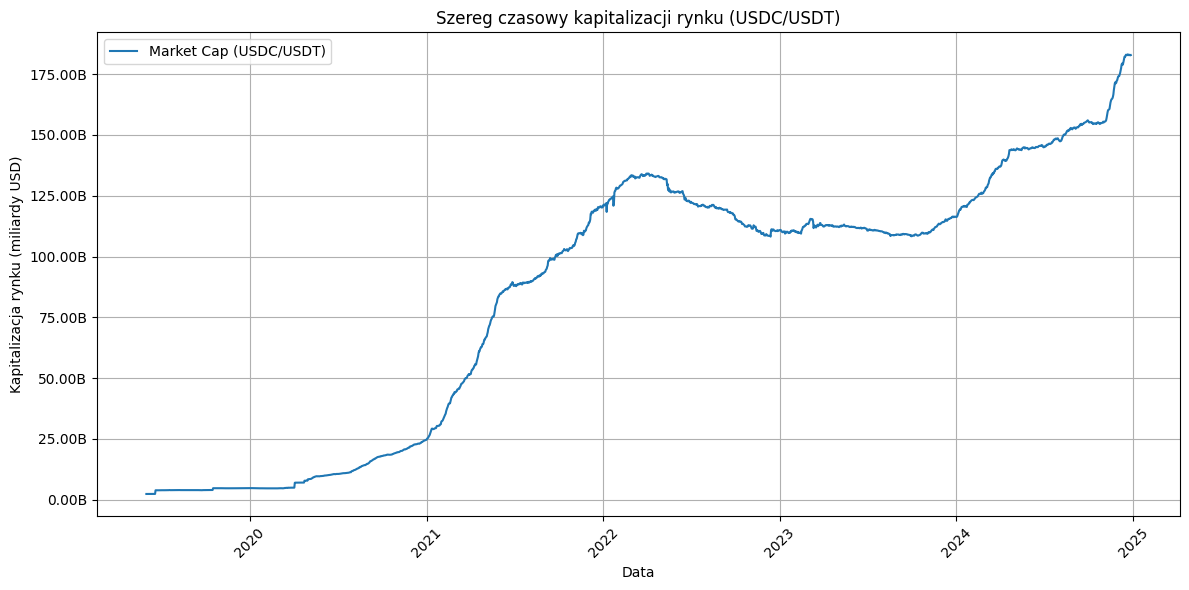

In [79]:
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_Y['snapped_at'], final_data_Y['total_market_cap_usdc_usdt'], label='Market Cap (USDC/USDT)', linewidth=1.5)

# Ustawienie formatu osi Y na miliardy
ax = plt.gca()  # Pobranie obiektu osi
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))  # Formatowanie w miliardach

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Kapitalizacja rynku (miliardy USD)')  # Odpowiednia jednostka
plt.title('Szereg czasowy kapitalizacji rynku (USDC/USDT)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [80]:
# Wykonanie testu ADF na zmiennej final_data_Y
result_y = adfuller(final_data_Y['total_market_cap_usdc_usdt'])

# Wyświetlenie wyników testu ADF
print('ADF Statistic:', result_y[0])
print('p-value:', result_y[1])
print('Critical Values:')
for key, value in result_y[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.24885464338723712
p-value: 0.9324421743682227
Critical Values:
   1%: -3.4335897947733383
   5%: -2.8629711750645868
   10%: -2.567531895054917


In [81]:
# Obliczenie różnicy pierwszego rzędu
final_data_Y_diff = final_data_Y['total_market_cap_usdc_usdt'].diff().dropna()

# Wykonanie testu ADF na różnicy pierwszego rzędu
result_diff_y = adfuller(final_data_Y_diff)

# Wyświetlenie wyników testu ADF
print('ADF Statistic (diff):', result_diff_y[0])
print('p-value (diff):', result_diff_y[1])
print('Critical Values (diff):')
for key, value in result_diff_y[4].items():
    print(f'   {key}: {value}')

ADF Statistic (diff): -5.419642962052484
p-value (diff): 3.0798515845553322e-06
Critical Values (diff):
   1%: -3.4335897947733383
   5%: -2.8629711750645868
   10%: -2.567531895054917


*Komentarz*: Zmienna Y jest I(1)

In [82]:
# Wykonanie testu Ljunga-Boxa na zmiennej Y
ljung_box_result_y = acorr_ljungbox(final_data_Y['total_market_cap_usdc_usdt'], lags=[10], return_df=True)

# Wyświetlenie wyników testu Ljunga-Boxa
print(ljung_box_result_y)

         lb_stat  lb_pvalue
10  20121.163594        0.0


Test Ljuga-Boxa, **Y**, mówi nam, ze jakas autokorelacja do 10 stopnia, wystepuje, ale nie bada jaka. 

In [83]:
# Wykonanie testu Ljunga-Boxa na różnicy pierwszego rzędu zmiennej Y
ljung_box_result_diff_y = acorr_ljungbox(final_data_Y_diff, lags=[10], return_df=True)

# Wyświetlenie wyników testu Ljunga-Boxa
print(ljung_box_result_diff_y)

       lb_stat     lb_pvalue
10  457.724974  4.698893e-92


Test Ljuga-Boxa, **dla Y I(1)**, mówi nam, ze jakas autokorelacja do 10 stopnia, wystepuje, ale nie bada jaka. 

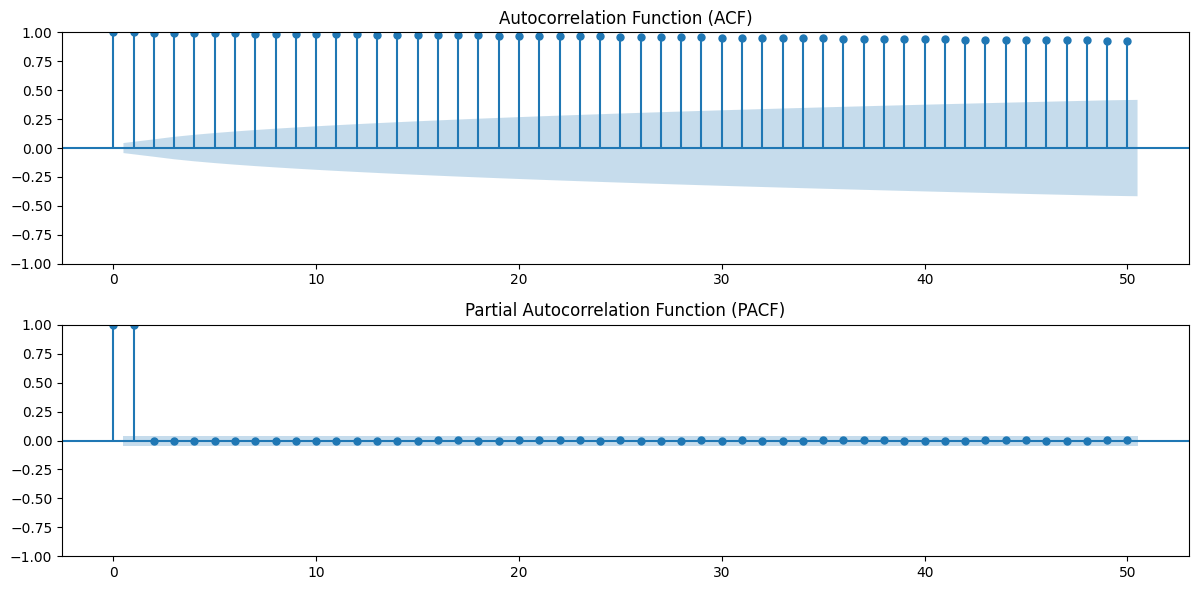

In [84]:
# Rysowanie wykresów ACF i PACF
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(2, 1, 1)
plot_acf(final_data_Y['total_market_cap_usdc_usdt'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Wykres PACF
plt.subplot(2, 1, 2)
plot_pacf(final_data_Y['total_market_cap_usdc_usdt'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

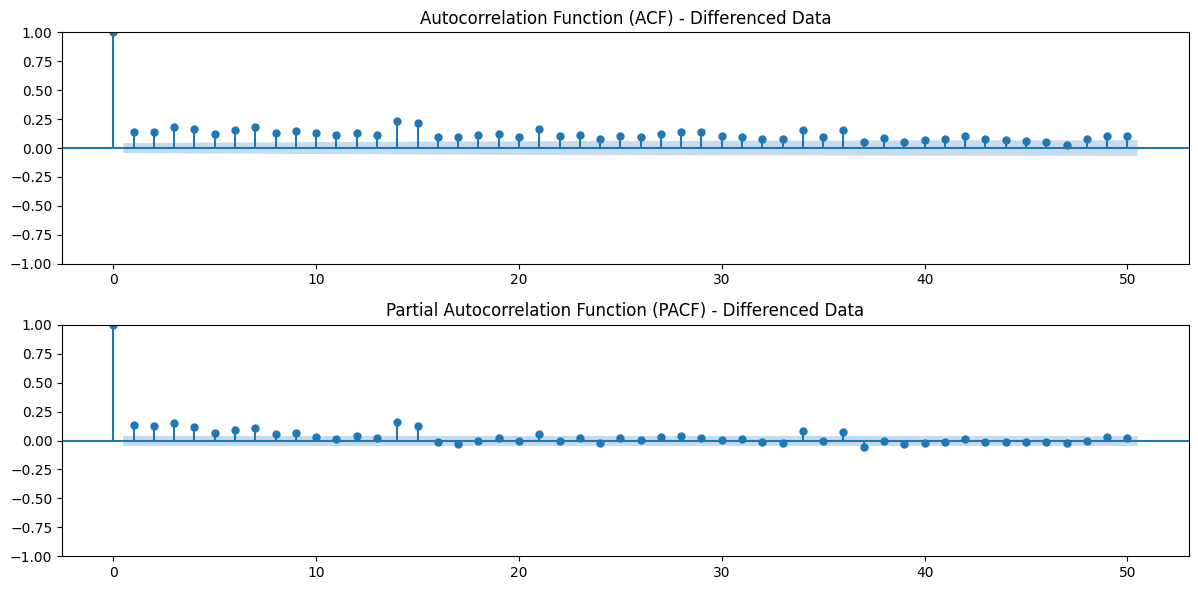

In [85]:
# Rysowanie wykresów ACF i PACF dla final_data_Y_diff
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(2, 1, 1)
plot_acf(final_data_Y_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Data')

# Wykres PACF
plt.subplot(2, 1, 2)
plot_pacf(final_data_Y_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Data')

plt.tight_layout()
plt.show()

In [92]:
# Obliczenie różnicy pierwszego rzędu zachowując strukturę DataFrame
final_data_Y_diff = final_data_Y.copy()
final_data_Y_diff['total_market_cap_usdc_usdt'] = final_data_Y_diff['total_market_cap_usdc_usdt'].diff()

# Usunięcie brakujących wartości (NaN) powstałych w wyniku różnicowania
final_data_Y_diff = final_data_Y_diff.dropna()

# Utworzenie zmiennej o 1 opóźnionej
final_data_Y_diff['total_market_cap_usdc_usdt_lagged'] = final_data_Y_diff['total_market_cap_usdc_usdt'].shift(1)

# Usunięcie brakujących wartości (NaN) powstałych w wyniku przesunięcia
final_data_Y_diff = final_data_Y_diff.dropna()

# Zachowanie tylko kolumn 'snapped_at' i 'total_market_cap_usdc_usdt_lagged'
final_data_Y_diff_lagged = final_data_Y_diff[['snapped_at', 'total_market_cap_usdc_usdt_lagged']]

# Wyświetlenie wyniku
print(final_data_Y_diff_lagged)

     snapped_at  total_market_cap_usdc_usdt_lagged
2    2019-06-03                       1.488963e+06
3    2019-06-04                      -6.565508e+06
4    2019-06-05                      -6.294234e+06
5    2019-06-06                       6.715487e+06
6    2019-06-07                       6.400550e+06
...         ...                                ...
2032 2024-12-23                      -2.968495e+08
2033 2024-12-24                      -3.923079e+07
2034 2024-12-25                       1.805161e+07
2035 2024-12-26                       1.566604e+08
2036 2024-12-27                      -2.535589e+08

[2035 rows x 2 columns]


#### Podsumowanie Autokorelacji i Opóźnień dla Y i Y I(1)

- Y niestacjonarna 
- Y I(1) stacjonarna 
- Ljung-Box dla Y i Y I(1), występuje autokorelacja 
- ACF i PACF dla Y - 1 stopnia 
- ACF i PACF dla Y I(1) - ja nie widzę wyraźnego stopnia opóźnienia 

# ETH/USD

Teraz przechodzę do zmiennej *ETH/USD* (note: ma więcej obserwacji, co zostanie podcięte przez inner join - zsotawiłem obserwację jakbym chciał w przyszlości wydłuyć szereg czasowy)

In [94]:
final_data_eth = data_eth[["snapped_at", "price"]]

print(final_data_eth)

     snapped_at        price
0    2019-06-01   268.126039
1    2019-06-02   264.727324
2    2019-06-03   269.938829
3    2019-06-04   251.752575
4    2019-06-05   240.239434
...         ...          ...
2032 2024-12-23  3275.889427
2033 2024-12-24  3414.641442
2034 2024-12-25  3497.555288
2035 2024-12-26  3494.510927
2036 2024-12-27  3327.789776

[2037 rows x 2 columns]


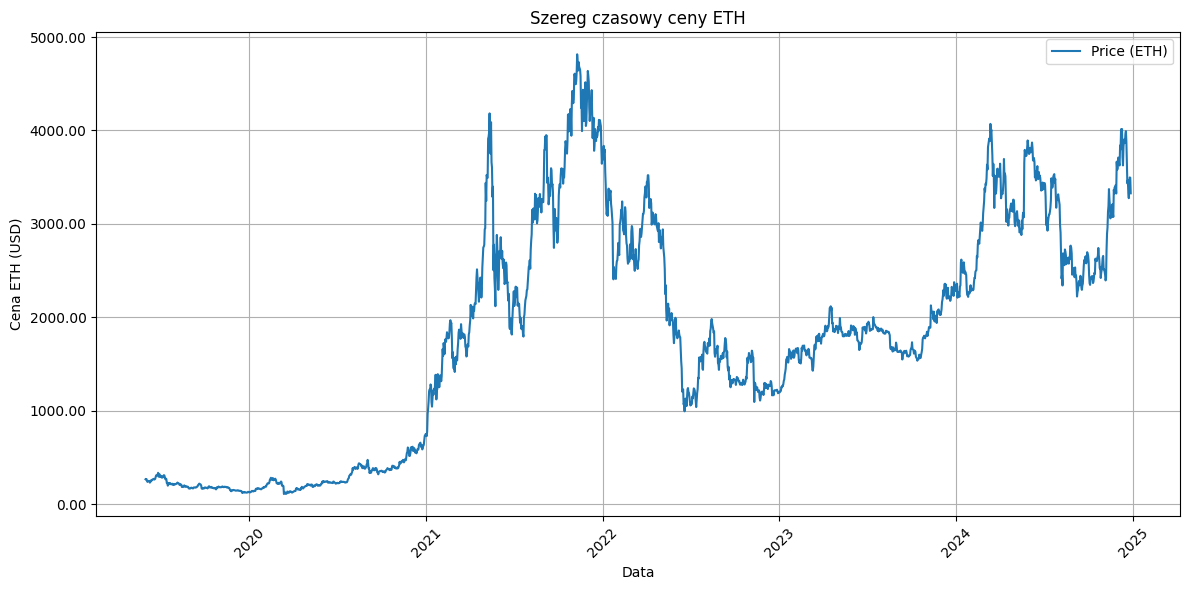

In [15]:
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_eth['snapped_at'], final_data_eth['price'], label='Price (ETH)', linewidth=1.5)

# Ustawienie formatu osi Y
ax = plt.gca()  # Pobranie obiektu osi
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Formatowanie z 2 miejscami po przecinku

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Cena ETH (USD)')  # Odpowiednia jednostka
plt.title('Szereg czasowy ceny ETH')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [56]:
# Test ADF dla surowych danych
result_eth = adfuller(final_data_eth['price'])

# Wyświetlenie wyników testu ADF dla surowych danych
print('ADF Statistic (raw):', result_eth[0])
print('p-value (raw):', result_eth[1])
print('Critical Values (raw):')
for key, value in result_eth[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): -1.6957259963682656
p-value (raw): 0.4333159066578839
Critical Values (raw):
   1%: -3.4335754129266802
   5%: -2.862964825335276
   10%: -2.567528514159528


In [57]:
# Obliczenie różnicy pierwszego rzędu
final_data_eth_diff = final_data_eth['price'].diff().dropna()

# Test ADF dla różnicy pierwszego rzędu
result_diff_eth = adfuller(final_data_eth_diff)

# Wyświetlenie wyników testu ADF dla różnicy pierwszego rzędu
print('ADF Statistic (diff):', result_diff_eth[0])
print('p-value (diff):', result_diff_eth[1])
print('Critical Values (diff):')
for key, value in result_diff_eth[4].items():
    print(f'   {key}: {value}')

ADF Statistic (diff): -17.48720470590797
p-value (diff): 4.456738352878112e-30
Critical Values (diff):
   1%: -3.4335754129266802
   5%: -2.862964825335276
   10%: -2.567528514159528


In [58]:
# Test Ljunga-Boxa dla surowych danych
ljung_box_result_eth = acorr_ljungbox(final_data_eth['price'], lags=[10], return_df=True)

# Wyświetlenie wyników testu Ljunga-Boxa dla surowych danych
print(ljung_box_result_eth)

         lb_stat  lb_pvalue
10  19693.097503        0.0


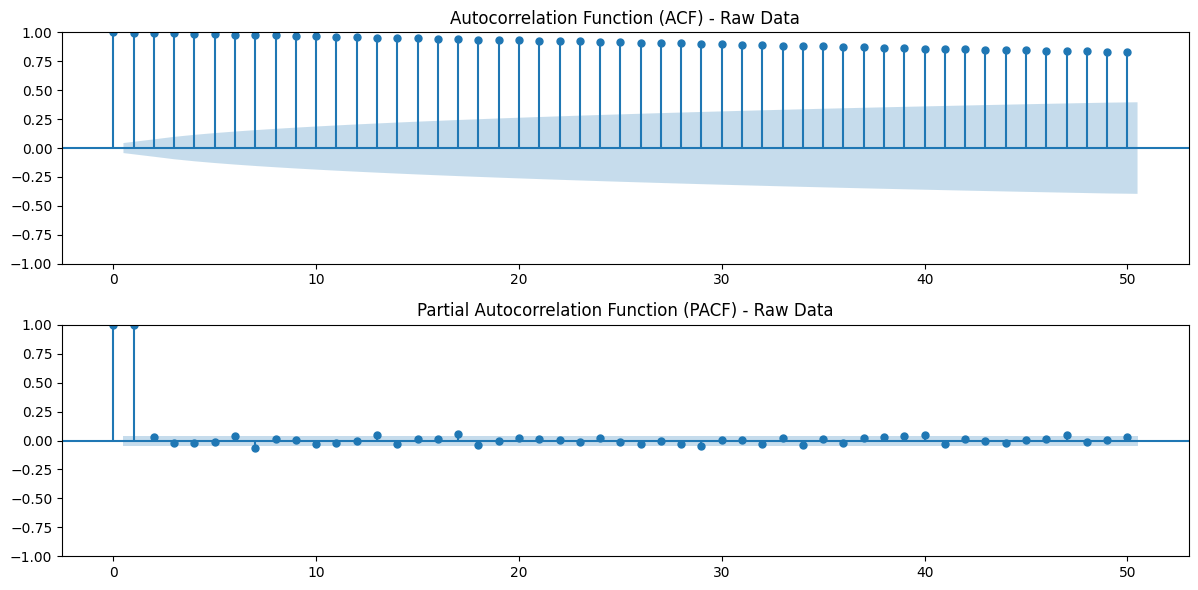

In [59]:
# Rysowanie wykresów ACF i PACF dla surowych danych
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(2, 1, 1)
plot_acf(final_data_eth['price'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw Data')

# Wykres PACF
plt.subplot(2, 1, 2)
plot_pacf(final_data_eth['price'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw Data')

plt.tight_layout()
plt.show()

In [60]:
# Test Ljunga-Boxa dla różnicy pierwszego rzędu
ljung_box_result_diff_eth = acorr_ljungbox(final_data_eth_diff, lags=[10], return_df=True)

# Wyświetlenie wyników testu Ljunga-Boxa dla różnicy pierwszego rzędu
print(ljung_box_result_diff_eth)

      lb_stat  lb_pvalue
10  32.120045   0.000382


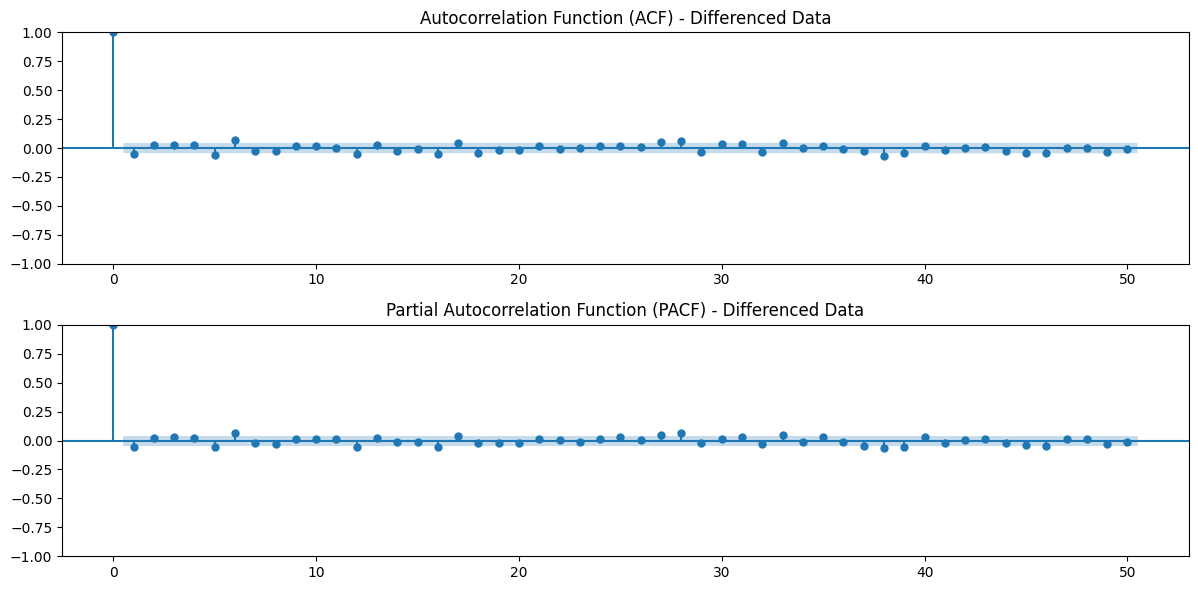

In [61]:
# Rysowanie wykresów ACF i PACF dla różnicy pierwszego rzędu
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(2, 1, 1)
plot_acf(final_data_eth_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Data')

# Wykres PACF
plt.subplot(2, 1, 2)
plot_pacf(final_data_eth_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Data')

plt.tight_layout()
plt.show()

In [95]:
# Obliczenie różnicy pierwszego rzędu zachowując strukturę DataFrame
final_data_eth_diff = final_data_eth.copy()
final_data_eth_diff['price'] = final_data_eth_diff['price'].diff()

# Usunięcie brakujących wartości (NaN) powstałych w wyniku różnicowania
final_data_eth_diff = final_data_eth_diff.dropna()

# Utworzenie zmiennej o 1 opóźnionej
final_data_eth_diff['price_lagged'] = final_data_eth_diff['price'].shift(1)

# Usunięcie brakujących wartości (NaN) powstałych w wyniku przesunięcia
final_data_eth_diff = final_data_eth_diff.dropna()

# Zachowanie tylko kolumn 'snapped_at' i 'price_lagged'
final_data_eth_diff_lagged = final_data_eth_diff[['snapped_at', 'price_lagged']]

# Wyświetlenie wyniku
print(final_data_eth_diff_lagged)

     snapped_at  price_lagged
2    2019-06-03     -3.398715
3    2019-06-04      5.211505
4    2019-06-05    -18.186254
5    2019-06-06    -11.513142
6    2019-06-07      6.587135
...         ...           ...
2032 2024-12-23   -131.061697
2033 2024-12-24    -61.707796
2034 2024-12-25    138.752015
2035 2024-12-26     82.913846
2036 2024-12-27     -3.044361

[2035 rows x 2 columns]


#### Podsumowanie Autokorelacji i Opóźnień dla ETH/USD i ETH/USD I(1)

- X niestacjonarna 
- X I(1) stacjonarna 
- Ljung-Box dla X i X I(1), występuje autokorelacja 
- ACF i PACF dla X - 1 stopnia 
- ACF i PACF dla X I(1) - ja nie widzę wyraźnego stopnia opóźnienia 

# S&P500

source: https://stooq.com/q/d/?s=%5Espx&c=0&d1=20190601&d2=20241227

In [97]:
final_data_spx = data_spx[["Date", "Close"]]

print(final_data_spx)

            Date    Close
0      3.06.2019  2744.45
1      4.06.2019  2803.27
2      5.06.2019  2826.15
3      6.06.2019  2843.49
4      7.06.2019  2873.34
...          ...      ...
1399  20.12.2024  5930.85
1400  23.12.2024  5974.07
1401  24.12.2024  6040.04
1402  26.12.2024  6037.59
1403  27.12.2024  5970.84

[1404 rows x 2 columns]


/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_20494/1452350471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_spx['Date'] = pd.to_datetime(final_data_spx['Date'], format='%d.%m.%Y')


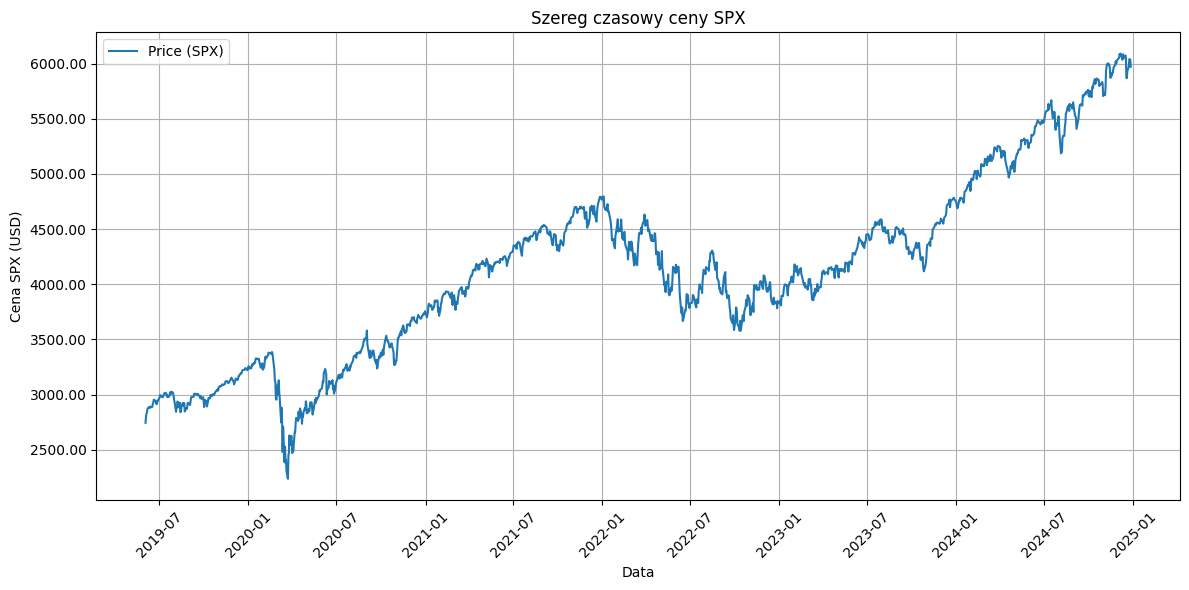

In [17]:
# Konwersja kolumny 'Date' na format datetime
final_data_spx['Date'] = pd.to_datetime(final_data_spx['Date'], format='%d.%m.%Y')

# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_spx['Date'], final_data_spx['Close'], label='Price (SPX)', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Ustawienie formatu np. "Rok-Miesiąc"
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Wyświetlanie co 6 miesięcy
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Ustawienie formatu osi Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Formatowanie z 2 miejscami po przecinku

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Cena SPX (USD)')  # Odpowiednia jednostka
plt.title('Szereg czasowy ceny SPX')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [62]:
# Test ADF dla surowych danych
result_spx = adfuller(final_data_spx['Close'])

# Wyświetlenie wyników testu ADF dla surowych danych
print('ADF Statistic (raw):', result_spx[0])
print('p-value (raw):', result_spx[1])
print('Critical Values (raw):')
for key, value in result_spx[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): -0.30385416904413337
p-value (raw): 0.9249566899803865
Critical Values (raw):
   1%: -3.435053080535985
   5%: -2.8636170711540054
   10%: -2.5678758266411537


In [98]:
# Calculate the first difference of the S&P500 data
final_data_spx_diff = final_data_spx['Close'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_spx = adfuller(final_data_spx_diff)

# Display the results of the ADF test
print('ADF Statistic (diff):', result_diff_spx[0])
print('p-value (diff):', result_diff_spx[1])
print('Critical Values (diff):')
for key, value in result_diff_spx[4].items():
    print(f'   {key}: {value}')

ADF Statistic (diff): -11.730804649255182
p-value (diff): 1.3431551075324715e-21
Critical Values (diff):
   1%: -3.435053080535985
   5%: -2.8636170711540054
   10%: -2.5678758266411537


In [68]:
# Perform the Ljung-Box test on the raw S&P500 data
ljung_box_result_spx = acorr_ljungbox(final_data_spx['Close'], lags=[10], return_df=True)

# Display the results of the Ljung-Box test
print(ljung_box_result_spx)

# Ljuung-Box on the first difference
ljung_box_result_diff_spx = acorr_ljungbox(final_data_spx_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test
print(ljung_box_result_diff_spx)

         lb_stat  lb_pvalue
10  13481.729402        0.0
     lb_stat     lb_pvalue
10  90.72214  3.851114e-15


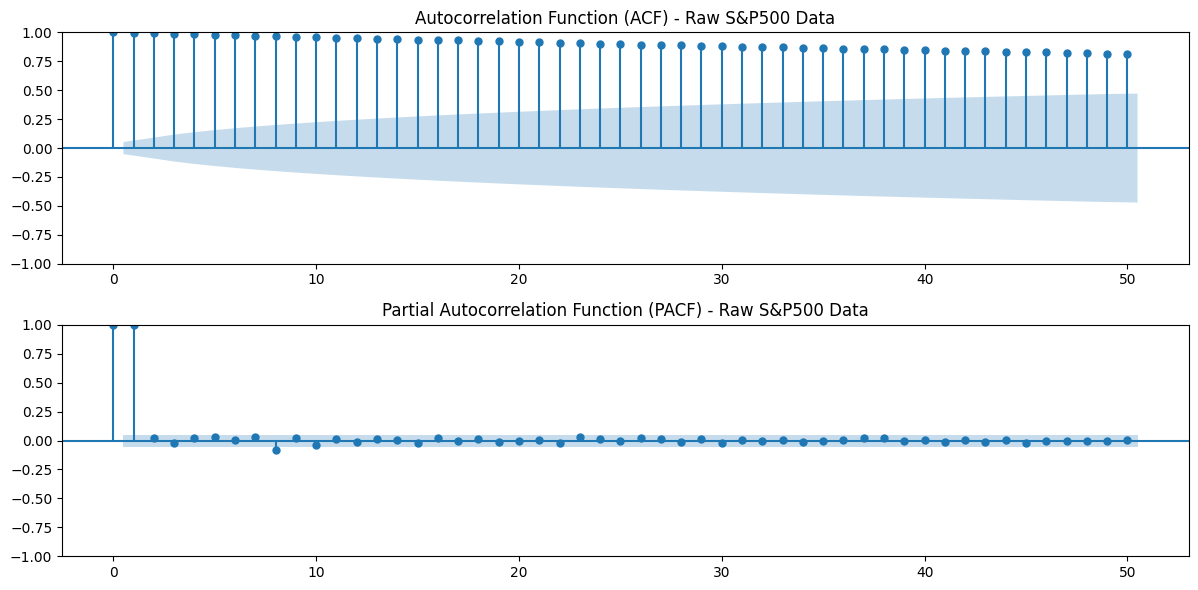

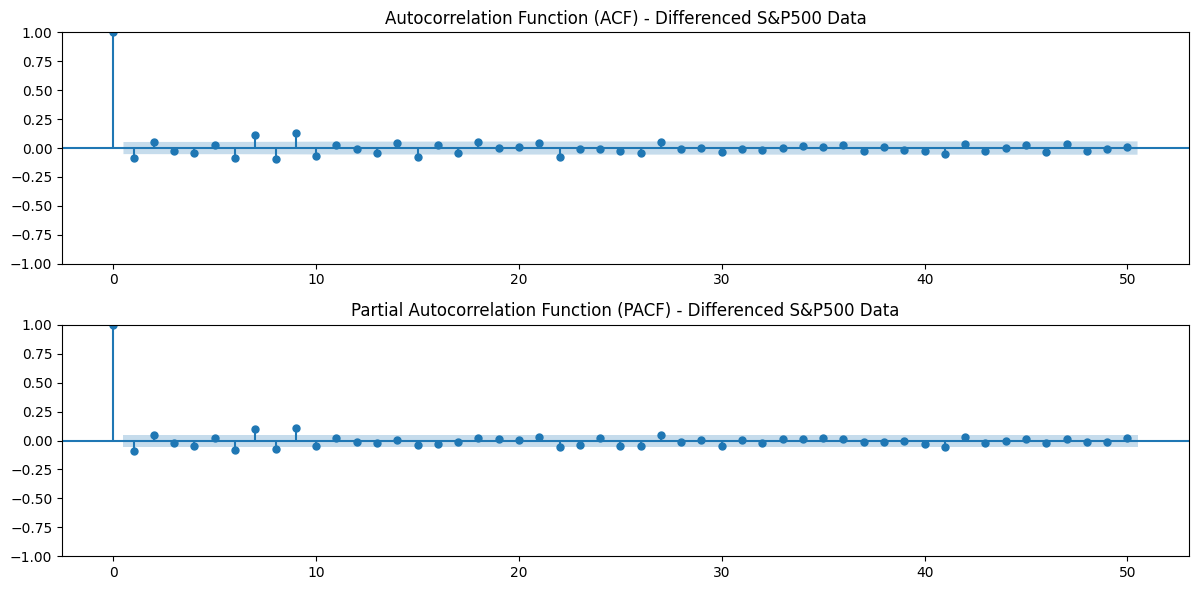

In [65]:
# Plotting ACF and PACF for raw S&P500 data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_spx['Close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw S&P500 Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_spx['Close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw S&P500 Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced S&P500 data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_spx_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced S&P500 Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_spx_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced S&P500 Data')

plt.tight_layout()
plt.show()

#### Podsumowanie Autokorelacji i Opóźnień dla S&P500

- X niestacjonarna 
- X I(1) stacjonarna 
- Ljung-Box dla X i X I(1), występuje autokorelacja 
- ACF i PACF dla X - 1 stopnia 
- ACF i PACF dla X I(1) - ja nie widzę wyraźnego stopnia opóźnienia 

In [100]:
# Obliczenie różnicy pierwszego rzędu zachowując strukturę DataFrame
final_data_spx_diff = final_data_spx.copy()
final_data_spx_diff['Close'] = final_data_spx_diff['Close'].diff()

# Usunięcie brakujących wartości (NaN) powstałych w wyniku różnicowania
final_data_spx_diff = final_data_spx_diff.dropna()

# Utworzenie zmiennej o 1 opóźnionej
final_data_spx_diff['Close_lagged'] = final_data_spx_diff['Close'].shift(1)

# Usunięcie brakujących wartości (NaN) powstałych w wyniku przesunięcia
final_data_spx_diff = final_data_spx_diff.dropna()

# Zachowanie tylko kolumn 'Date' i 'Close_lagged'
final_data_spx_diff_lagged = final_data_spx_diff[['Date', 'Close_lagged']]

# Wyświetlenie wyniku
print(final_data_spx_diff_lagged)

            Date  Close_lagged
2      5.06.2019         58.82
3      6.06.2019         22.88
4      7.06.2019         17.34
5     10.06.2019         29.85
6     11.06.2019         13.39
...          ...           ...
1399  20.12.2024         -5.08
1400  23.12.2024         63.77
1401  24.12.2024         43.22
1402  26.12.2024         65.97
1403  27.12.2024         -2.45

[1402 rows x 2 columns]


### U.S. Dollar Index (USD_I)

source: https://stooq.pl/q/d/?s=usd_i

In [104]:
final_data_usd_l = data_usd_l[["Date", "Close"]]
print(final_data_usd_l)

            Date    Close
0      3.06.2019  72.4528
1      4.06.2019  72.3235
2      5.06.2019  72.4070
3      6.06.2019  72.3236
4      7.06.2019  72.0815
...          ...      ...
1438  23.12.2024  76.7792
1439  24.12.2024  76.8705
1440  25.12.2024  76.7593
1441  26.12.2024  76.8580
1442  27.12.2024  76.6727

[1443 rows x 2 columns]


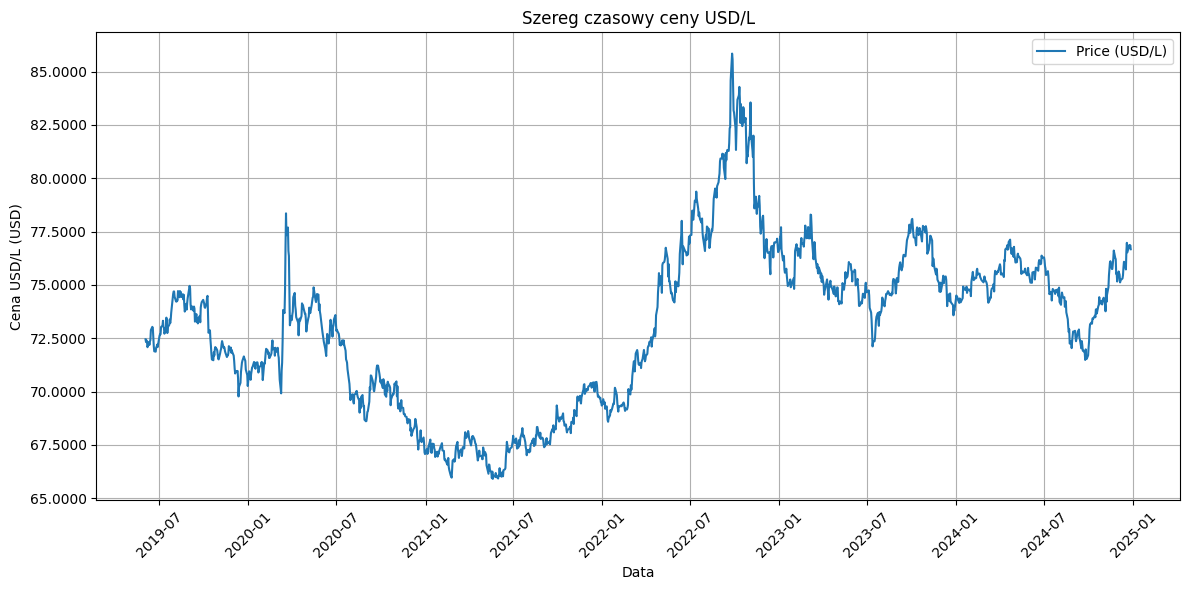

In [105]:
final_data_usd_l = final_data_usd_l.copy()  # Tworzenie kopii
final_data_usd_l['Date'] = pd.to_datetime(final_data_usd_l['Date'], format='%d.%m.%Y')  # Konwersja dat

# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_usd_l['Date'], final_data_usd_l['Close'], label='Price (USD/L)', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Ustawienie formatu np. "Rok-Miesiąc"
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Wyświetlanie co 6 miesięcy
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Ustawienie formatu osi Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Formatowanie z 4 miejscami po przecinku

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Cena USD/L (USD)')  # Odpowiednia jednostka
plt.title('Szereg czasowy ceny USD/L')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [106]:
# Perform the ADF test on the 'Close' column of final_data_usd_l
result_usd_l = adfuller(final_data_usd_l['Close'])

# Display the results of the ADF test
print('ADF Statistic:', result_usd_l[0])
print('p-value:', result_usd_l[1])
print('Critical Values:')
for key, value in result_usd_l[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.5576983392714163
p-value: 0.5048005619518418
Critical Values:
   1%: -3.434911997169608
   5%: -2.863554810504947
   10%: -2.567842671398422


In [70]:
# Calculate the first difference of the USD/L data
final_data_usd_l_diff = final_data_usd_l['Close'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_usd_l = adfuller(final_data_usd_l_diff)

# Display the results of the ADF test
print('ADF Statistic (diff):', result_diff_usd_l[0])
print('p-value (diff):', result_diff_usd_l[1])
print('Critical Values (diff):')
for key, value in result_diff_usd_l[4].items():
    print(f'   {key}: {value}')

ADF Statistic (diff): -17.46007175550214
p-value (diff): 4.60240813683079e-30
Critical Values (diff):
   1%: -3.434911997169608
   5%: -2.863554810504947
   10%: -2.567842671398422


In [71]:
# Perform the Ljung-Box test on the raw USD/L data
ljung_box_result_usd_l = acorr_ljungbox(final_data_usd_l['Close'], lags=[10], return_df=True)

# Display the results of the Ljung-Box test for raw data
print("Ljung-Box Test for Raw USD/L Data:")
print(ljung_box_result_usd_l)

# Perform the Ljung-Box test on the differenced USD/L data
ljung_box_result_diff_usd_l = acorr_ljungbox(final_data_usd_l_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test for differenced data
print("\nLjung-Box Test for Differenced USD/L Data:")
print(ljung_box_result_diff_usd_l)

Ljung-Box Test for Raw USD/L Data:
         lb_stat  lb_pvalue
10  13699.701463        0.0

Ljung-Box Test for Differenced USD/L Data:
      lb_stat  lb_pvalue
10  26.862901   0.002738


ADF Statistic (raw): -1.5576983392714163
p-value (raw): 0.5048005619518418
Critical Values (raw):
   1%: -3.434911997169608
   5%: -2.863554810504947
   10%: -2.567842671398422
ADF Statistic (diff): -17.46007175550214
p-value (diff): 4.60240813683079e-30
Critical Values (diff):
   1%: -3.434911997169608
   5%: -2.863554810504947
   10%: -2.567842671398422


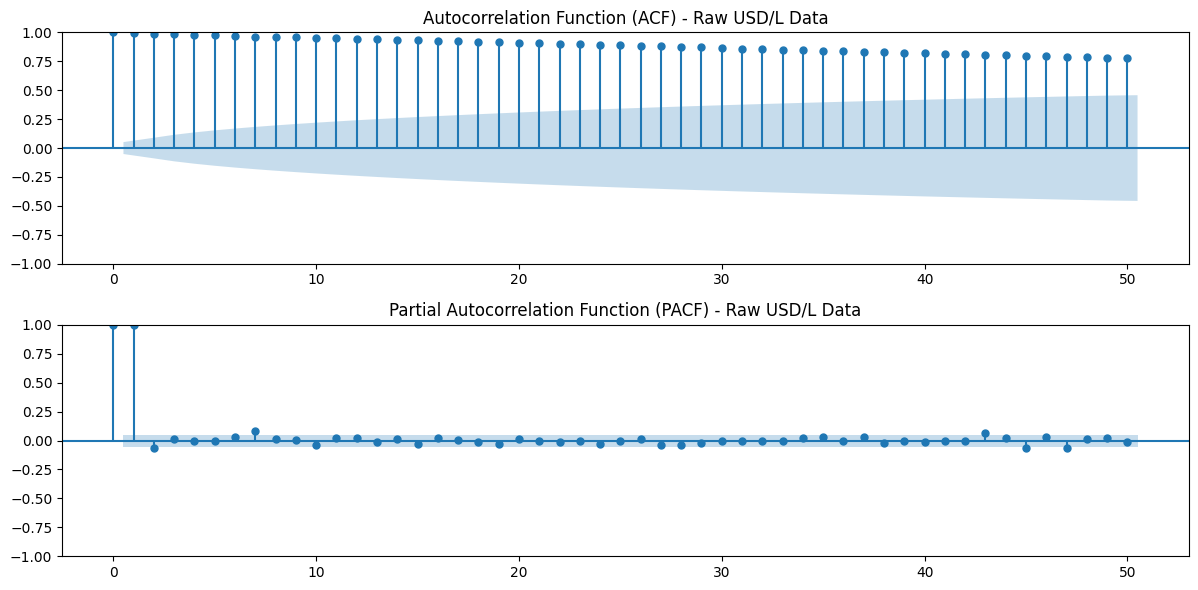

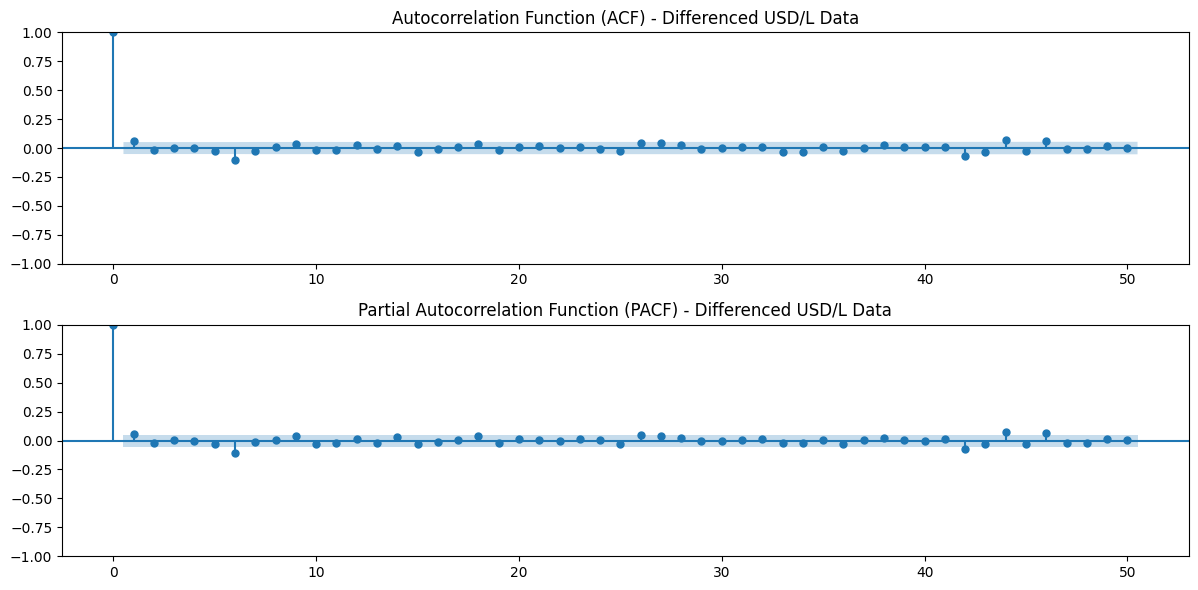

In [72]:
# ADF test for raw USD/L data
result_usd_l = adfuller(final_data_usd_l['Close'])
print('ADF Statistic (raw):', result_usd_l[0])
print('p-value (raw):', result_usd_l[1])
print('Critical Values (raw):')
for key, value in result_usd_l[4].items():
    print(f'   {key}: {value}')

# ADF test for differenced USD/L data
result_diff_usd_l = adfuller(final_data_usd_l_diff)
print('ADF Statistic (diff):', result_diff_usd_l[0])
print('p-value (diff):', result_diff_usd_l[1])
print('Critical Values (diff):')
for key, value in result_diff_usd_l[4].items():
    print(f'   {key}: {value}')

# Plotting ACF and PACF for raw USD/L data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_usd_l['Close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw USD/L Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_usd_l['Close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw USD/L Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced USD/L data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_usd_l_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced USD/L Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_usd_l_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced USD/L Data')

plt.tight_layout()
plt.show()

In [108]:
# Obliczenie różnicy pierwszego rzędu zachowując strukturę DataFrame
final_data_usd_l_diff = final_data_usd_l.copy()
final_data_usd_l_diff['Close'] = final_data_usd_l_diff['Close'].diff()

# Usunięcie brakujących wartości (NaN) powstałych w wyniku różnicowania
final_data_usd_l_diff = final_data_usd_l_diff.dropna()

# Utworzenie zmiennej o 1 opóźnionej
final_data_usd_l_diff['Close_lagged'] = final_data_usd_l_diff['Close'].shift(1)

# Usunięcie brakujących wartości (NaN) powstałych w wyniku przesunięcia
final_data_usd_l_diff = final_data_usd_l_diff.dropna()

# Zachowanie tylko kolumn 'Date' i 'Close_lagged'
final_data_usd_l_diff_lagged = final_data_usd_l_diff[['Date', 'Close_lagged']]

# Wyświetlenie wyniku
print(final_data_usd_l_diff_lagged)

           Date  Close_lagged
3    2019-06-06        0.0835
4    2019-06-07       -0.0834
5    2019-06-10       -0.2421
6    2019-06-11        0.2421
7    2019-06-12       -0.1337
...         ...           ...
1438 2024-12-23       -0.4469
1439 2024-12-24        0.2522
1440 2024-12-25        0.0913
1441 2024-12-26       -0.1112
1442 2024-12-27        0.0987

[1440 rows x 2 columns]


#### Podsumowanie Autokorelacji i Opóźnień dla USD/L

- X niestacjonarna 
- X I(1) stacjonarna 
- Ljung-Box dla X i X I(1), występuje autokorelacja 
- ACF i PACF dla X - 1 stopnia 
- ACF i PACF dla X I(1) - ja nie widzę wyraźnego stopnia opóźnienia 

# Indeks zmiennosci rynków (VIX)

source: https://fred.stlouisfed.org/series/VIXCLS

In [110]:
print(data_vix)

     observation_date  VIXCLS
0          2019-06-03   18.86
1          2019-06-04   16.97
2          2019-06-05   16.09
3          2019-06-06   15.93
4          2019-06-07   16.30
...               ...     ...
1450       2024-12-23   16.78
1451       2024-12-24   14.27
1452       2024-12-25     NaN
1453       2024-12-26   14.73
1454       2024-12-27   15.95

[1455 rows x 2 columns]


In [111]:
# Zakładam, że final_data_vix jest już utworzony
final_data_vix = data_vix.copy()

# Konwersja kolumny 'observation_date' na format datetime i zmiana na format DD.MM.YYYY
final_data_vix['observation_date'] = pd.to_datetime(final_data_vix['observation_date'], format='%Y-%m-%d').dt.strftime('%-d.%m.%Y')

# Usunięcie brakujących wartości (NaN)
final_data_vix = final_data_vix.dropna()

# Wyświetlenie wyniku
print(final_data_vix)

     observation_date  VIXCLS
0           3.06.2019   18.86
1           4.06.2019   16.97
2           5.06.2019   16.09
3           6.06.2019   15.93
4           7.06.2019   16.30
...               ...     ...
1449       20.12.2024   18.36
1450       23.12.2024   16.78
1451       24.12.2024   14.27
1453       26.12.2024   14.73
1454       27.12.2024   15.95

[1423 rows x 2 columns]


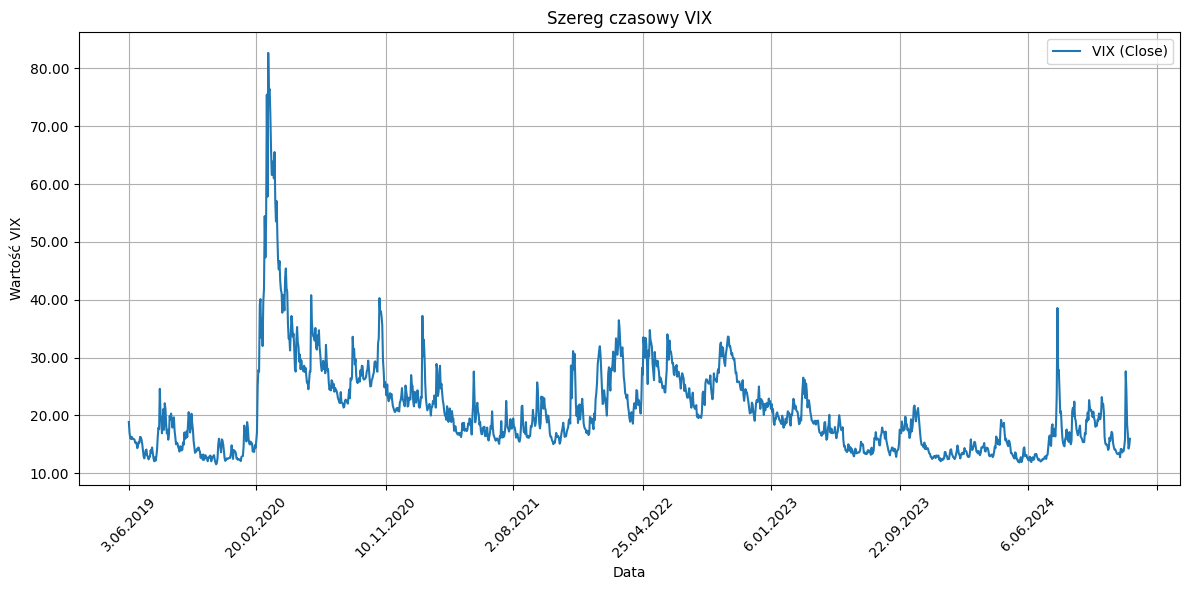

In [22]:
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_vix['observation_date'], final_data_vix['VIXCLS'], label='VIX (Close)', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Wyświetlanie dat co 6 miesięcy
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Ustawienie formatu osi Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Formatowanie z 2 miejscami po przecinku

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Wartość VIX')  # Odpowiednia jednostka
plt.title('Szereg czasowy VIX')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [73]:
# Perform the ADF test on the VIX data
result_vix = adfuller(final_data_vix['VIXCLS'].dropna())

# Display the results of the ADF test
print('ADF Statistic:', result_vix[0])
print('p-value:', result_vix[1])
print('Critical Values:')
for key, value in result_vix[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -4.241039626201584
p-value: 0.0005610729814833327
Critical Values:
   1%: -3.4349863902854607
   5%: -2.863587640846308
   10%: -2.567860154259632


In [74]:
# Calculate the first difference of the VIX data
final_data_vix_diff = final_data_vix['VIXCLS'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_vix = adfuller(final_data_vix_diff)

# Display the results of the ADF test
print('ADF Statistic (diff):', result_diff_vix[0])
print('p-value (diff):', result_diff_vix[1])
print('Critical Values (diff):')
for key, value in result_diff_vix[4].items():
    print(f'   {key}: {value}')

ADF Statistic (diff): -12.622756191535597
p-value (diff): 1.565195884073335e-23
Critical Values (diff):
   1%: -3.4349863902854607
   5%: -2.863587640846308
   10%: -2.567860154259632


In [75]:
# Perform the Ljung-Box test on the raw VIX data
ljung_box_result_vix = acorr_ljungbox(final_data_vix['VIXCLS'].dropna(), lags=[10], return_df=True)

# Display the results of the Ljung-Box test for raw data
print("Ljung-Box Test for Raw VIX Data:")
print(ljung_box_result_vix)

# Perform the Ljung-Box test on the differenced VIX data
ljung_box_result_diff_vix = acorr_ljungbox(final_data_vix_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test for differenced data
print("\nLjung-Box Test for Differenced VIX Data:")
print(ljung_box_result_diff_vix)

Ljung-Box Test for Raw VIX Data:
       lb_stat  lb_pvalue
10  10734.6614        0.0

Ljung-Box Test for Differenced VIX Data:
       lb_stat     lb_pvalue
10  148.593687  7.255281e-27


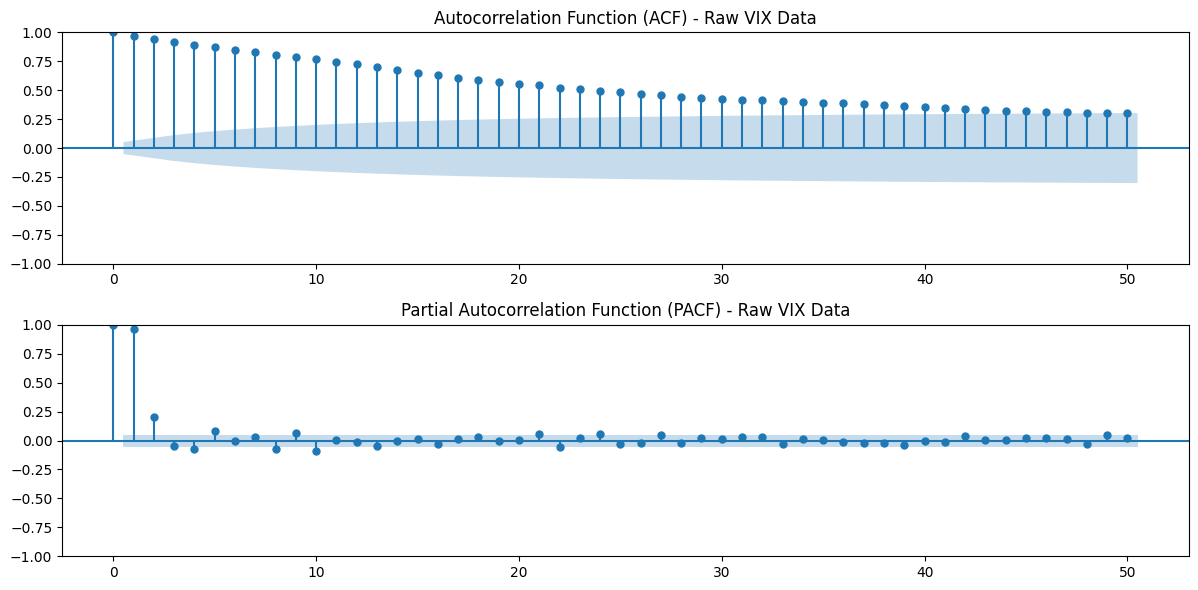

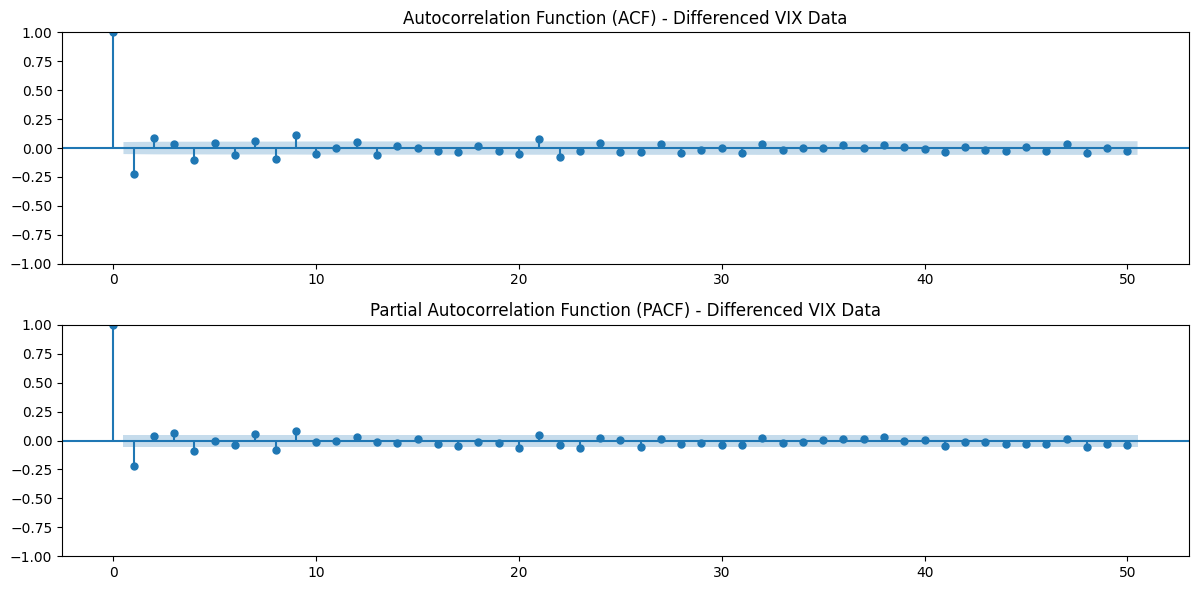

In [76]:
# Plotting ACF and PACF for raw VIX data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_vix['VIXCLS'].dropna(), lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw VIX Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_vix['VIXCLS'].dropna(), lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw VIX Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced VIX data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_vix_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced VIX Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_vix_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced VIX Data')

plt.tight_layout()
plt.show()

In [137]:
# Create a lagged variable for the VIX data
final_data_vix['VIXCLS_lagged'] = final_data_vix['VIXCLS'].shift(1)

# Keep the original and lagged variables along with the date
final_data_vix_lagged = final_data_vix[['observation_date', 'VIXCLS', 'VIXCLS_lagged']] # tu jak cos .dropna()

# Display the result
print(final_data_vix_lagged)

     observation_date  VIXCLS  VIXCLS_lagged
0           3.06.2019   18.86            NaN
1           4.06.2019   16.97          18.86
2           5.06.2019   16.09          16.97
3           6.06.2019   15.93          16.09
4           7.06.2019   16.30          15.93
...               ...     ...            ...
1449       20.12.2024   18.36          24.09
1450       23.12.2024   16.78          18.36
1451       24.12.2024   14.27          16.78
1453       26.12.2024   14.73          14.27
1454       27.12.2024   15.95          14.73

[1423 rows x 3 columns]


In [134]:
# Calculate the first difference of the VIX data
final_data_vix_diff = final_data_vix['VIXCLS'].diff().dropna()

# Create a lagged variable for the differenced VIX data
final_data_vix_diff_lagged = final_data_vix_diff.shift(1).dropna()

# Combine the differenced data and the lagged variable into a DataFrame
final_data_vix_diff_lagged_df = pd.DataFrame({
    'observation_date': final_data_vix['observation_date'][1:],  # Adjust the index to match the differenced data
    'VIXCLS_diff': final_data_vix_diff,
    'VIXCLS_diff_lagged': final_data_vix_diff_lagged
}).dropna()

# Display the result
print(final_data_vix_diff_lagged_df)

     observation_date  VIXCLS_diff  VIXCLS_diff_lagged
2           5.06.2019        -0.88               -1.89
3           6.06.2019        -0.16               -0.88
4           7.06.2019         0.37               -0.16
5          10.06.2019        -0.36                0.37
6          11.06.2019         0.05               -0.36
...               ...          ...                 ...
1449       20.12.2024        -5.73               -3.53
1450       23.12.2024        -1.58               -5.73
1451       24.12.2024        -2.51               -1.58
1453       26.12.2024         0.46               -2.51
1454       27.12.2024         1.22                0.46

[1421 rows x 3 columns]


* Pamiętaj, zeby z tego df wyciagnąc dwie zmienne diffy i diffy_lagged

#### Podsumowanie Autokorelacji i Opóźnień dla VIX

- X stacjonarna 
- X I(1) stacjonarna 
- Ljung-Box dla X i X I(1), występuje autokorelacja 
- ACF i PACF dla X - 1 stopnia 
- ACF i PACF dla X I(1) - ?

# Rynkowa rentowność 2-letnich obligacji USA

source: https://stooq.pl/q/d/?s=2yusy.b&c=0&d1=20190601&d2=20241227

In [23]:
print(data_2yusy)

            Data   Open   High    Low  Close
0     2019-06-03  1.910  1.910  1.828  1.840
1     2019-06-04  1.865  1.926  1.861  1.883
2     2019-06-05  1.843  1.873  1.779  1.857
3     2019-06-06  1.826  1.895  1.818  1.881
4     2019-06-07  1.876  1.882  1.785  1.853
...          ...    ...    ...    ...    ...
1390  2024-12-20  4.319  4.325  4.259  4.321
1391  2024-12-23  4.325  4.357  4.321  4.342
1392  2024-12-24  4.345  4.374  4.339  4.349
1393  2024-12-26  4.353  4.372  4.332  4.337
1394  2024-12-27  4.337  4.351  4.314  4.339

[1395 rows x 5 columns]


In [24]:
# Zakładam, że data_2yusy to Twój DataFrame
final_data_2yusy = data_2yusy.copy()

# Konwersja kolumny "Data" na format DD.MM.YYYY
final_data_2yusy['Data'] = pd.to_datetime(final_data_2yusy['Data'], format='%Y-%m-%d').dt.strftime('%-d.%m.%Y')

# Zachowanie tylko kolumn "Data" i "Close"
final_data_2yusy = final_data_2yusy[['Data', 'Close']]

# Wyświetlenie wyniku
print(final_data_2yusy)

            Data  Close
0      3.06.2019  1.840
1      4.06.2019  1.883
2      5.06.2019  1.857
3      6.06.2019  1.881
4      7.06.2019  1.853
...          ...    ...
1390  20.12.2024  4.321
1391  23.12.2024  4.342
1392  24.12.2024  4.349
1393  26.12.2024  4.337
1394  27.12.2024  4.339

[1395 rows x 2 columns]


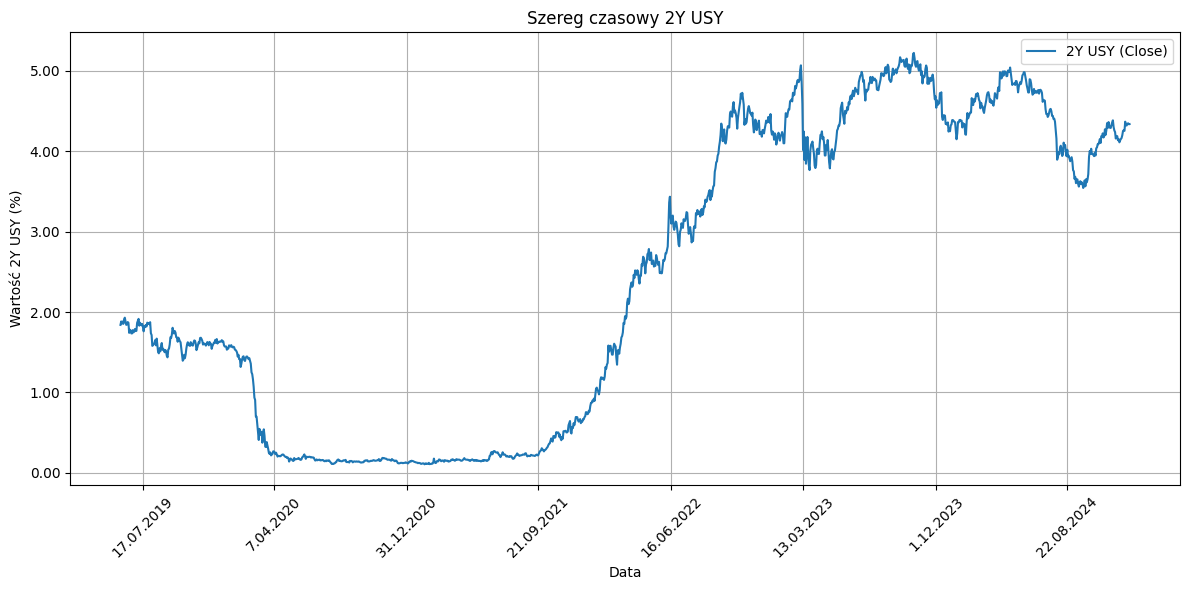

In [25]:
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_2yusy['Data'], final_data_2yusy['Close'], label='2Y USY (Close)', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Wyświetlanie dat co 6 miesięcy
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Ustawienie formatu osi Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Formatowanie z 2 miejscami po przecinku

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Wartość 2Y USY (%)')  # Jednostka: procenty
plt.title('Szereg czasowy 2Y USY')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [77]:
# Perform the ADF test on the 'Close' column of final_data_2yusy
result_2yusy = adfuller(final_data_2yusy['Close'])

# Display the results of the ADF test
print('ADF Statistic (raw):', result_2yusy[0])
print('p-value (raw):', result_2yusy[1])
print('Critical Values (raw):')
for key, value in result_2yusy[4].items():
    print(f'   {key}: {value}')

# Calculate the first difference of the 2Y USY data
final_data_2yusy_diff = final_data_2yusy['Close'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_2yusy = adfuller(final_data_2yusy_diff)

# Display the results of the ADF test
print('ADF Statistic (diff):', result_diff_2yusy[0])
print('p-value (diff):', result_diff_2yusy[1])
print('Critical Values (diff):')
for key, value in result_diff_2yusy[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): -0.3471136633873925
p-value (raw): 0.9185615002312553
Critical Values (raw):
   1%: -3.435097467737946
   5%: -2.8636366587977804
   10%: -2.5678862576139467
ADF Statistic (diff): -9.071849829654937
p-value (diff): 4.281087045292753e-15
Critical Values (diff):
   1%: -3.435097467737946
   5%: -2.8636366587977804
   10%: -2.5678862576139467


In [78]:
# Perform the Ljung-Box test on the raw 2Y USY data
ljung_box_result_2yusy = acorr_ljungbox(final_data_2yusy['Close'], lags=[10], return_df=True)

# Display the results of the Ljung-Box test for raw data
print("Ljung-Box Test for Raw 2Y USY Data:")
print(ljung_box_result_2yusy)

# Perform the Ljung-Box test on the differenced 2Y USY data
ljung_box_result_diff_2yusy = acorr_ljungbox(final_data_2yusy_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test for differenced data
print("\nLjung-Box Test for Differenced 2Y USY Data:")
print(ljung_box_result_diff_2yusy)

Ljung-Box Test for Raw 2Y USY Data:
         lb_stat  lb_pvalue
10  13881.282505        0.0

Ljung-Box Test for Differenced 2Y USY Data:
      lb_stat  lb_pvalue
10  23.237272   0.009904


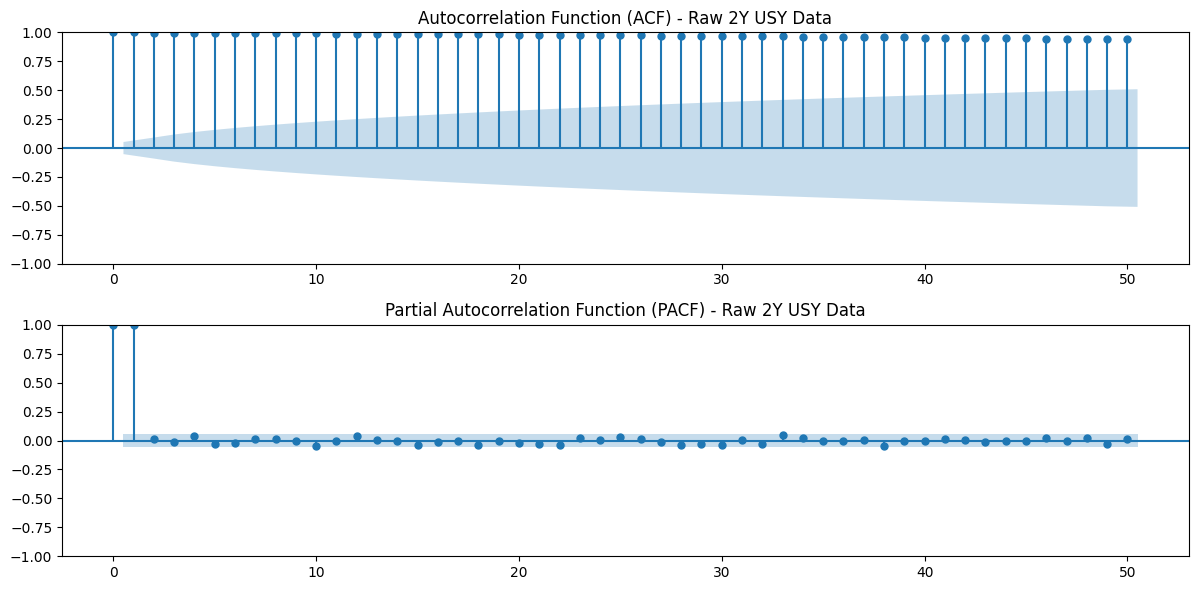

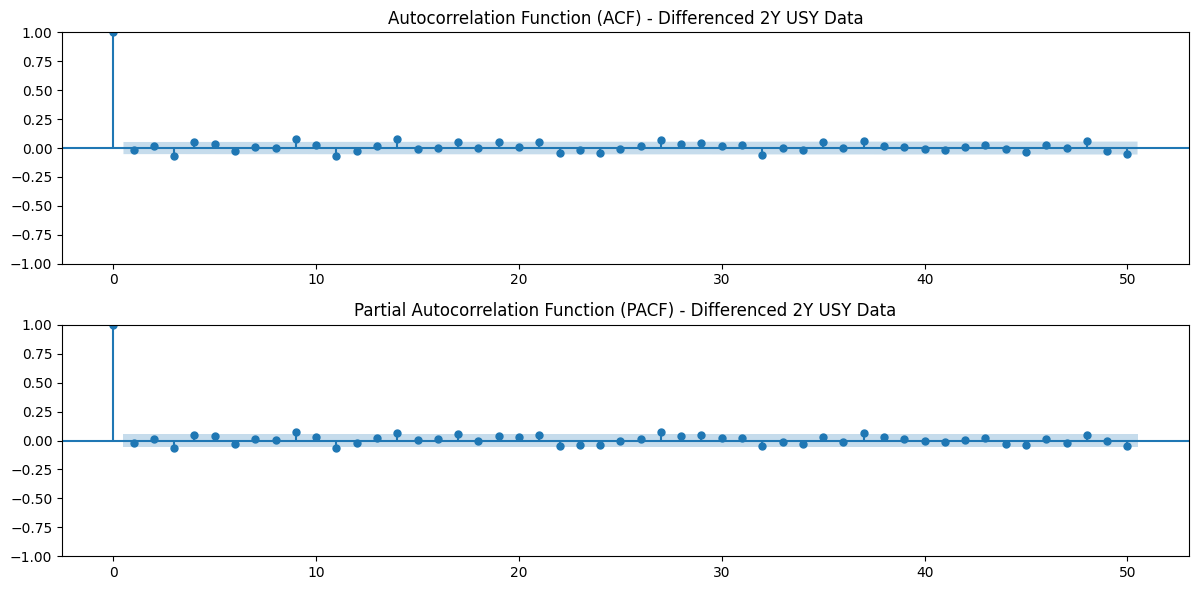

In [79]:
# Plotting ACF and PACF for raw 2Y USY data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_2yusy['Close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw 2Y USY Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_2yusy['Close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw 2Y USY Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced 2Y USY data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_2yusy_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced 2Y USY Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_2yusy_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced 2Y USY Data')

plt.tight_layout()
plt.show()

### Wycena rynku zdecentralizowanych finansów (DeFi)

source: DeFillama

In [26]:
print(data_defi_tvl)

            Protocol    27/04/2018     28/04/2018   29/04/2018     30/04/2018  \
0              Total  404077.85881  400585.099213  429213.9332  421651.156158   
1         TokenStore  404077.85881  400585.099213  429213.9332  421651.156158   
2            Hats.V1           NaN            NaN          NaN            NaN   
3        Compound V1           NaN            NaN          NaN            NaN   
4         Uniswap V1           NaN            NaN          NaN            NaN   
...              ...           ...            ...          ...            ...   
3347   Neemo Finance           NaN            NaN          NaN            NaN   
3348          Zarban           NaN            NaN          NaN            NaN   
3349           Sonex           NaN            NaN          NaN            NaN   
3350  Citrex Markets           NaN            NaN          NaN            NaN   
3351          edBank           NaN            NaN          NaN            NaN   

         01/05/2018     02/

In [27]:
# Wybór wiersza, gdzie 'Protocol' jest równe 'Total', oraz przekształcenie tabeli
worked_data_tvl = data_defi_tvl[data_defi_tvl['Protocol'] == 'Total']

# Przekształcenie szerokiej tabeli na długi format, gdzie kolumny z datami stają się wartościami w jednej kolumnie
worked_data_tvl = worked_data_tvl.melt(id_vars=['Protocol'], var_name='Date', value_name='Total')

# Usunięcie kolumny 'Protocol', ponieważ wszystkie wartości są "Total"
worked_data_tvl = worked_data_tvl[['Date', 'Total']]

# Wyświetlenie wyniku
print(worked_data_tvl)

            Date         Total
0     27/04/2018  4.040779e+05
1     28/04/2018  4.005851e+05
2     29/04/2018  4.292139e+05
3     30/04/2018  4.216512e+05
4     01/05/2018  4.361950e+05
...          ...           ...
2454  14/01/2025  1.153186e+11
2455  15/01/2025  1.190497e+11
2456  16/01/2025  1.250858e+11
2457  17/01/2025  1.229605e+11
2458  18/01/2025  1.245105e+11

[2459 rows x 2 columns]


Zmiana formatu *Date* i wycięcie potrzebnego nam fragmetu szeregu czasowego 

In [28]:
# Konwersja kolumny 'Date' na format datetime, aby można było filtrować zakres dat
worked_data_tvl['Date'] = pd.to_datetime(worked_data_tvl['Date'], format='%d/%m/%Y')

# Filtrowanie dat od 01.06.2019 do 27.12.2024
final_data_tvl = worked_data_tvl[
    (worked_data_tvl['Date'] >= '2019-06-01') & (worked_data_tvl['Date'] <= '2024-12-27')
]

# Zmiana formatu daty na 27.04.2018
final_data_tvl['Date'] = final_data_tvl['Date'].dt.strftime('%d.%m.%Y')

# Wyświetlenie wyniku
print(final_data_tvl)

            Date         Total
400   01.06.2019  4.649003e+08
401   02.06.2019  4.904402e+08
402   03.06.2019  4.923165e+08
403   04.06.2019  4.800295e+08
404   05.06.2019  4.491084e+08
...          ...           ...
2432  23.12.2024  1.189153e+11
2433  24.12.2024  1.225740e+11
2434  25.12.2024  1.255206e+11
2435  26.12.2024  1.253588e+11
2436  27.12.2024  1.207371e+11

[2037 rows x 2 columns]


/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_20494/2560208816.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_tvl['Date'] = final_data_tvl['Date'].dt.strftime('%d.%m.%Y')


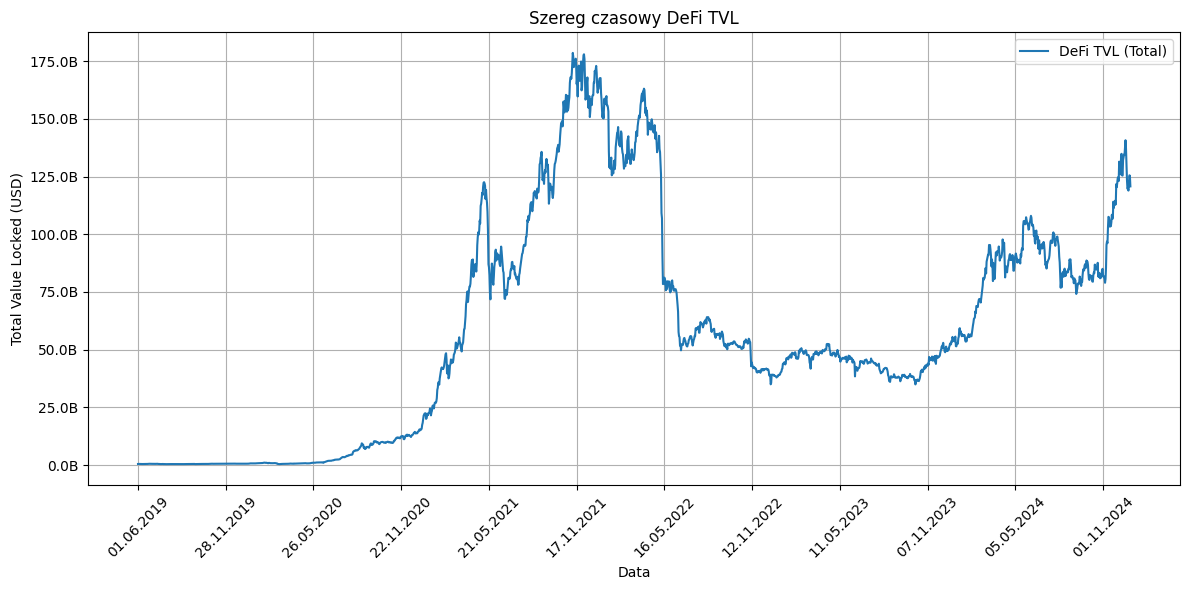

In [29]:
# Funkcja formatowania osi Y na miliardy
def billions_formatter(x, _):
    return f'{x / 1e9:.1f}B'  # Dzielimy przez 1e9 i dodajemy "B" dla miliardów

# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_tvl['Date'], final_data_tvl['Total'], label='DeFi TVL (Total)', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.set_xticks(final_data_tvl['Date'][::180])  # Wyświetlanie co 180 dni (co około 6 miesięcy)
plt.xticks(rotation=45)  # Obrót etykiet na osi X

ax.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Total Value Locked (USD)')  # Jednostka: dolary
plt.title('Szereg czasowy DeFi TVL')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

In [80]:
# Perform the ADF test on the 'Total' column of final_data_tvl
result_tvl = adfuller(final_data_tvl['Total'])

# Display the results of the ADF test for raw data
print('ADF Statistic (raw):', result_tvl[0])
print('p-value (raw):', result_tvl[1])
print('Critical Values (raw):')
for key, value in result_tvl[4].items():
    print(f'   {key}: {value}')

# Calculate the first difference of the TVL data
final_data_tvl_diff = final_data_tvl['Total'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_tvl = adfuller(final_data_tvl_diff)

# Display the results of the ADF test for differenced data
print('ADF Statistic (diff):', result_diff_tvl[0])
print('p-value (diff):', result_diff_tvl[1])
print('Critical Values (diff):')
for key, value in result_diff_tvl[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): -1.2521090967061874
p-value (raw): 0.6507879911066095
Critical Values (raw):
   1%: -3.4335754129266802
   5%: -2.862964825335276
   10%: -2.567528514159528
ADF Statistic (diff): -16.514250640724192
p-value (diff): 2.0923259845770004e-29
Critical Values (diff):
   1%: -3.4335754129266802
   5%: -2.862964825335276
   10%: -2.567528514159528


In [81]:
# Perform the Ljung-Box test on the raw TVL data
ljung_box_result_tvl = acorr_ljungbox(final_data_tvl['Total'], lags=[10], return_df=True)

# Display the results of the Ljung-Box test for raw data
print("Ljung-Box Test for Raw TVL Data:")
print(ljung_box_result_tvl)

# Perform the Ljung-Box test on the differenced TVL data
ljung_box_result_diff_tvl = acorr_ljungbox(final_data_tvl_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test for differenced data
print("\nLjung-Box Test for Differenced TVL Data:")
print(ljung_box_result_diff_tvl)

Ljung-Box Test for Raw TVL Data:
        lb_stat  lb_pvalue
10  19962.58876        0.0

Ljung-Box Test for Differenced TVL Data:
      lb_stat     lb_pvalue
10  57.584533  1.035004e-08


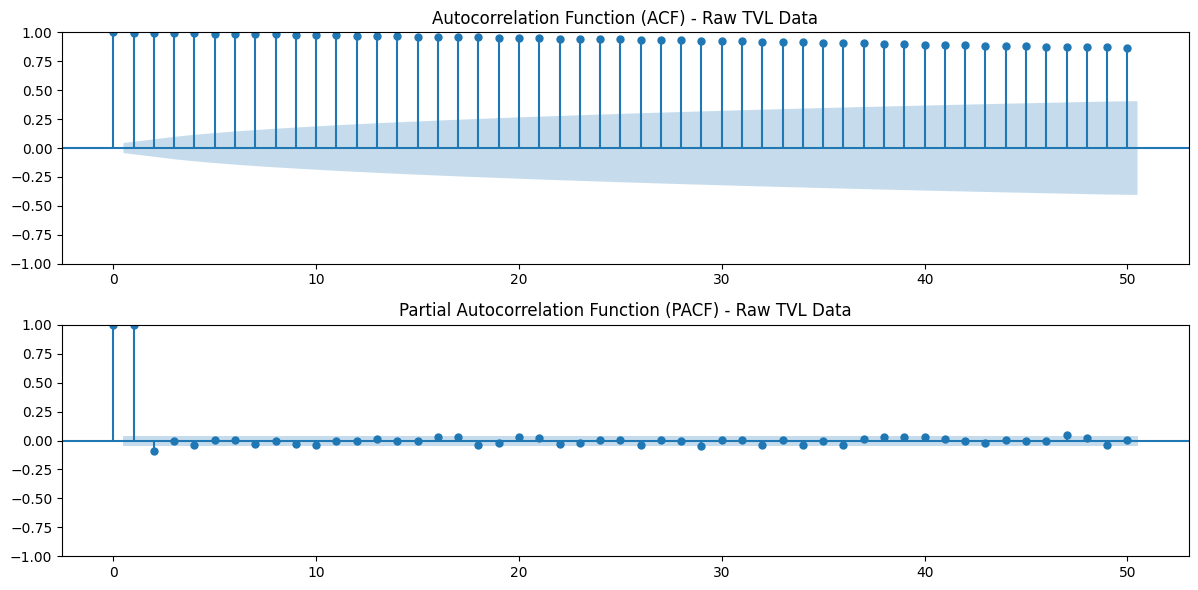

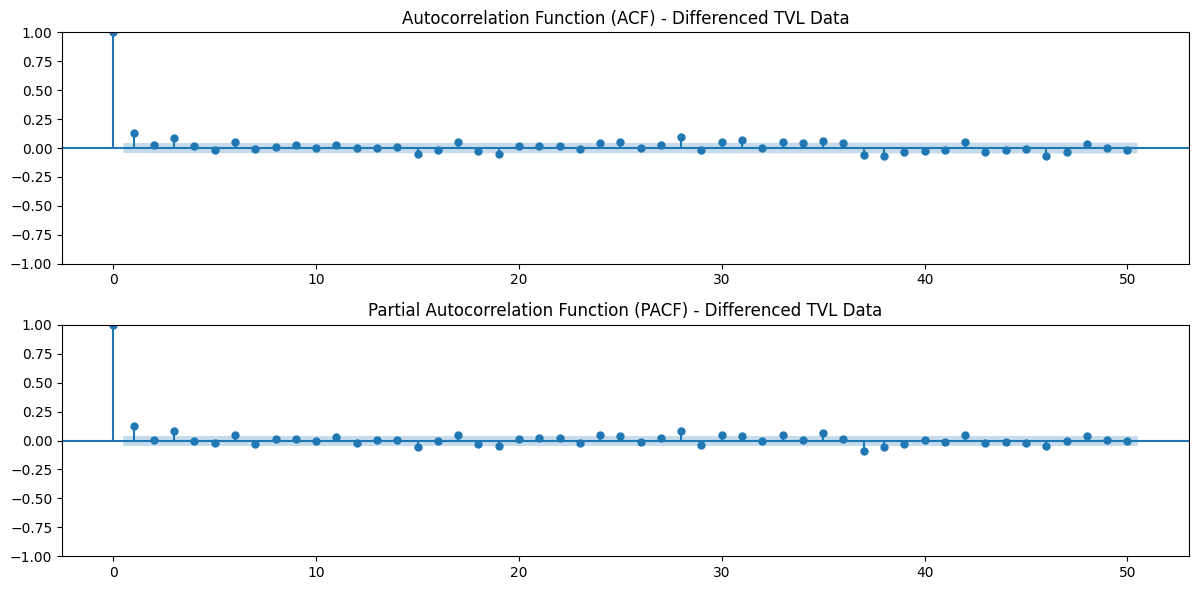

In [82]:
# Plotting ACF and PACF for raw TVL data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_tvl['Total'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw TVL Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_tvl['Total'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw TVL Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced TVL data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_tvl_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced TVL Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_tvl_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced TVL Data')

plt.tight_layout()
plt.show()

### Ilość Aktywnych Użytkowników Stablecoinów

source: https://app.artemis.xyz/stablecoins | active addresses | aggregate: 1d


In [19]:
print(data_stables_active_addresses)

           Date   AUSD    BUSD      DAI    EURC   FDUSD   PYUSD   USD0  \
0     28-Nov-17    NaN     NaN      NaN     NaN     NaN     NaN    NaN   
1     29-Nov-17    NaN     NaN      NaN     NaN     NaN     NaN    NaN   
2     30-Nov-17    NaN     NaN      NaN     NaN     NaN     NaN    NaN   
3     01-Dec-17    NaN     NaN      NaN     NaN     NaN     NaN    NaN   
4     02-Dec-17    NaN     NaN      NaN     NaN     NaN     NaN    NaN   
...         ...    ...     ...      ...     ...     ...     ...    ...   
2602  12-Jan-25  130.0  5540.0  12364.0  2365.0   308.0  2649.0  223.0   
2603  13-Jan-25  226.0  7613.0  16063.0  1252.0   469.0  3237.0  156.0   
2604  14-Jan-25  274.0  4733.0  13924.0  2532.0   375.0  3589.0  137.0   
2605  15-Jan-25  324.0  5457.0  15228.0  2597.0   879.0  3843.0  197.0   
2606  16-Jan-25  219.0  5326.0  14835.0  1174.0  1244.0  3629.0  147.0   

          USDC  USDGLO  USDP    USDS       USDT   USDY    USDe   cEUR  cKES  \
0          NaN     NaN   NaN    

In [ ]:
# Konwersja kolumny "Date" na datetime
data_stables_active_addresses['Date'] = pd.to_datetime(data_stables_active_addresses['Date'], format='%d-%b-%y')

# Filtrowanie dat od 01.06.2019 do 27.12.2024
filtered_data = data_stables_active_addresses[
    (data_stables_active_addresses['Date'] >= '2019-06-01') & 
    (data_stables_active_addresses['Date'] <= '2024-12-27')
]

# Obliczenie kolumny 'Total' jako suma użytkowników wszystkich stablecoinów
filtered_data['Total'] = filtered_data.iloc[:, 1:].sum(axis=1)

# Zmiana formatu daty na DD.MM.YYYY
filtered_data['Date'] = filtered_data['Date'].dt.strftime('%d.%m.%Y')

# Zatrzymanie tylko kolumn "Date" i "Total"
final_data_stables_active_addresses = filtered_data[['Date', 'Total']]

# Wyświetlenie wyniku
print(final_data_stables_active_addresses)

            Date      Total
550   01.06.2019     5252.0
551   02.06.2019     5407.0
552   03.06.2019     6338.0
553   04.06.2019     7313.0
554   05.06.2019     7574.0
...          ...        ...
2582  23.12.2024  2542945.0
2583  24.12.2024  2480838.0
2584  25.12.2024  2349401.0
2585  26.12.2024  2430858.0
2586  27.12.2024  2479157.0

[2037 rows x 2 columns]


/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/2630165686.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Total'] = filtered_data.iloc[:, 1:].sum(axis=1)
/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/2630165686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Date'] = filtered_data['Date'].dt.strftime('%d.%m.%Y')


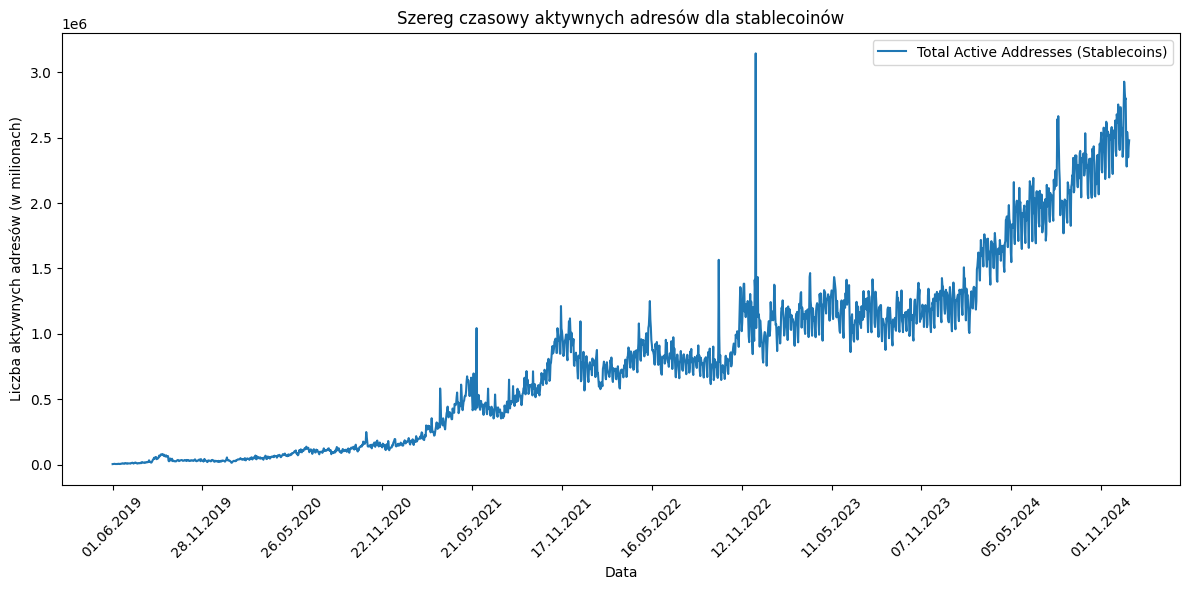

In [ ]:
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_stables_active_addresses['Date'], final_data_stables_active_addresses['Total'], 
         label='Total Active Addresses (Stablecoins)', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.set_xticks(final_data_stables_active_addresses['Date'][::180])  # Wyświetlanie co 180 dni (co około 6 miesięcy)
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Ustawienie osi Y
plt.xlabel('Data')  # Opis osi X
plt.ylabel('Liczba aktywnych adresów (w milionach)')  # Opis osi Y
plt.title('Szereg czasowy aktywnych adresów dla stablecoinów')  # Tytuł wykresu
plt.legend()  # Dodanie legendy
plt.tight_layout()  # Dostosowanie layoutu

# Wyświetlenie wykresu
plt.show()

In [ ]:
# Perform the ADF test on the 'Total' column of final_data_stables_active_addresses
result_active_addresses = adfuller(final_data_stables_active_addresses['Total'])

# Display the results of the ADF test for raw data
print('ADF Statistic (raw):', result_active_addresses[0])
print('p-value (raw):', result_active_addresses[1])
print('Critical Values (raw):')
for key, value in result_active_addresses[4].items():
    print(f'   {key}: {value}')

# Calculate the first difference of the active addresses data
final_data_stables_active_addresses_diff = final_data_stables_active_addresses['Total'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_active_addresses = adfuller(final_data_stables_active_addresses_diff)

# Display the results of the ADF test for differenced data
print('ADF Statistic (diff):', result_diff_active_addresses[0])
print('p-value (diff):', result_diff_active_addresses[1])
print('Critical Values (diff):')
for key, value in result_diff_active_addresses[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): 1.3808846925612095
p-value (raw): 0.9970255502409205
Critical Values (raw):
   1%: -3.4336075477138945
   5%: -2.862979013123536
   10%: -2.567536068414148
ADF Statistic (diff): -12.780249790377333
p-value (diff): 7.442106197411652e-24
Critical Values (diff):
   1%: -3.4336091712699957
   5%: -2.862979729933645
   10%: -2.567536450078678


In [32]:
# Perform the Ljung-Box test on the raw data
ljung_box_result_active_addresses = acorr_ljungbox(final_data_stables_active_addresses['Total'], lags=[10], return_df=True)

# Display the results of the Ljung-Box test for raw data
print("Ljung-Box Test for Raw Active Addresses Data:")
print(ljung_box_result_active_addresses)

# Perform the Ljung-Box test on the differenced data
ljung_box_result_diff_active_addresses = acorr_ljungbox(final_data_stables_active_addresses_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test for differenced data
print("\nLjung-Box Test for Differenced Active Addresses Data:")
print(ljung_box_result_diff_active_addresses)

Ljung-Box Test for Raw Active Addresses Data:
         lb_stat  lb_pvalue
10  19187.218421        0.0

Ljung-Box Test for Differenced Active Addresses Data:
       lb_stat      lb_pvalue
10  554.365147  1.042990e-112


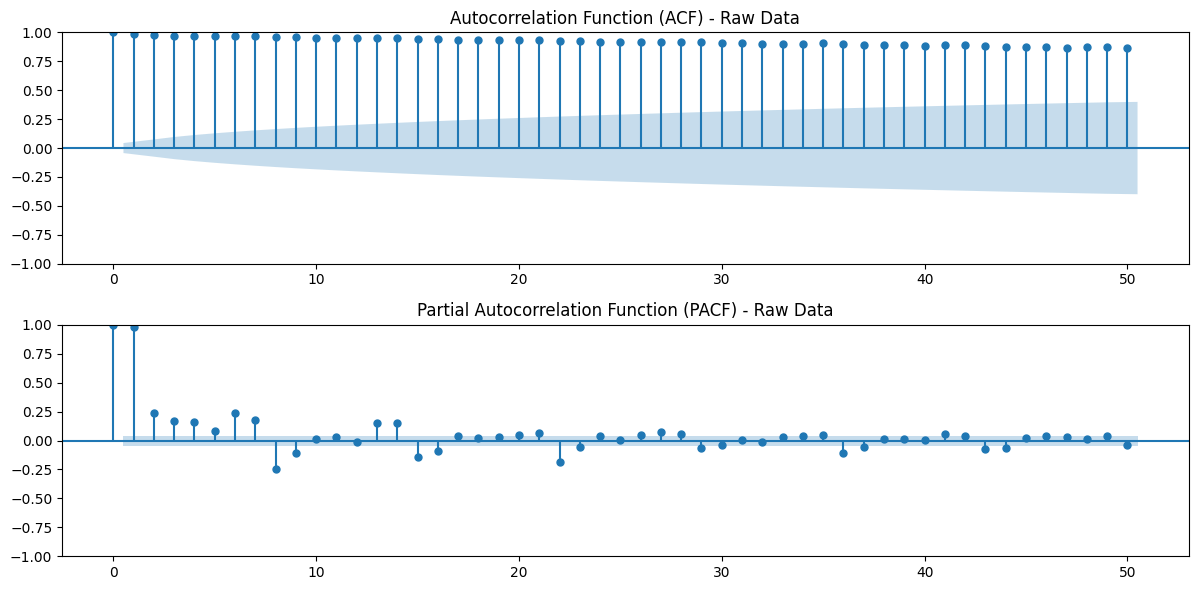

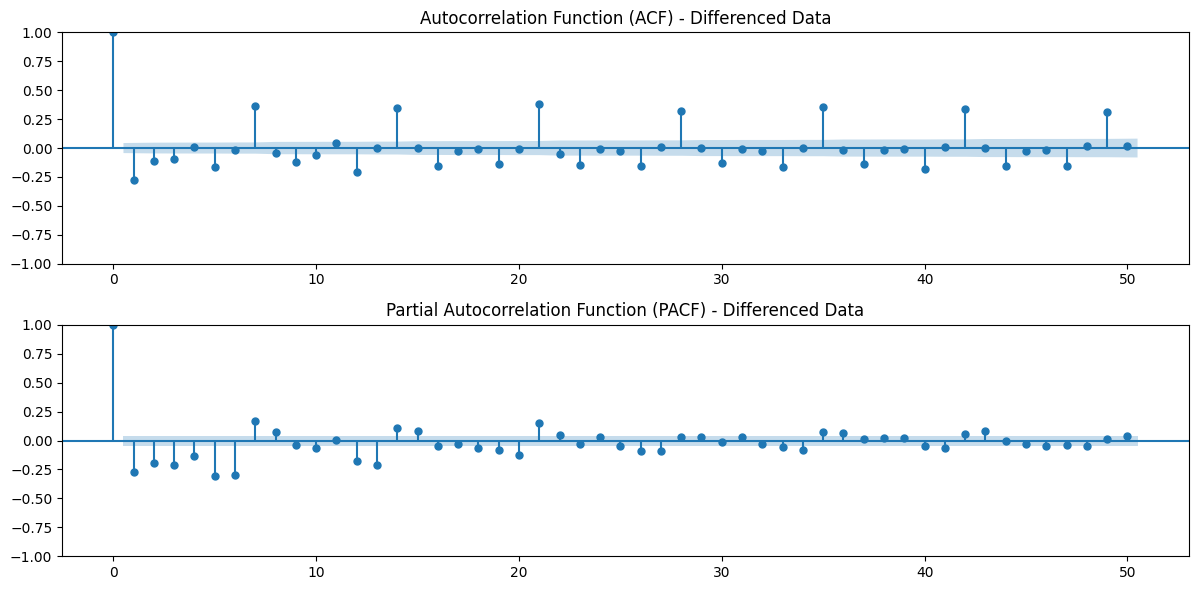

In [33]:
# Rysowanie wykresów ACF i PACF dla final_data_stables_active_addresses
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(2, 1, 1)
plot_acf(final_data_stables_active_addresses['Total'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw Data')

# Wykres PACF
plt.subplot(2, 1, 2)
plot_pacf(final_data_stables_active_addresses['Total'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw Data')

plt.tight_layout()
plt.show()

# Rysowanie wykresów ACF i PACF dla final_data_stables_active_addresses_diff
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(2, 1, 1)
plot_acf(final_data_stables_active_addresses_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Data')

# Wykres PACF
plt.subplot(2, 1, 2)
plot_pacf(final_data_stables_active_addresses_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Data')

plt.tight_layout()
plt.show()

### Liczba transakcji z wykorzystaniem stablecoinów

source: https://app.artemis.xyz/stablecoins | *Transfers* | Aggregate: 1d

In [23]:
print(data_stables_transfers)

           Date     AUSD      BUSD       DAI     EURC    FDUSD    PYUSD  \
0     28-Nov-17      NaN       NaN       NaN      NaN      NaN      NaN   
1     29-Nov-17      NaN       NaN       NaN      NaN      NaN      NaN   
2     30-Nov-17      NaN       NaN       NaN      NaN      NaN      NaN   
3     01-Dec-17      NaN       NaN       NaN      NaN      NaN      NaN   
4     02-Dec-17      NaN       NaN       NaN      NaN      NaN      NaN   
...         ...      ...       ...       ...      ...      ...      ...   
2602  12-Jan-25   5941.0   71743.0  141902.0  14680.0   2533.0  32331.0   
2603  13-Jan-25  12405.0  118504.0  221623.0  32490.0   5545.0  47168.0   
2604  14-Jan-25   9103.0   84806.0  176722.0  26003.0   3886.0  48236.0   
2605  15-Jan-25  10201.0   88951.0  184865.0  26741.0   9090.0  53777.0   
2606  16-Jan-25   5384.0   84589.0  197012.0  26168.0  12915.0  64936.0   

        USD0        USDC  USDGLO  USDP     USDS        USDT    USDY     USDe  \
0        NaN       

In [ ]:
# Konwersja kolumny "Date" na datetime
data_stables_transfers['Date'] = pd.to_datetime(data_stables_transfers['Date'], format='%d-%b-%y')

# Filtrowanie dat od 01.06.2019 do 27.12.2024
filtered_transfers = data_stables_transfers[
    (data_stables_transfers['Date'] >= '2019-06-01') & 
    (data_stables_transfers['Date'] <= '2024-12-27')
]

# Obliczenie kolumny 'Total' jako suma transferów wszystkich stablecoinów
filtered_transfers['Total'] = filtered_transfers.iloc[:, 1:].sum(axis=1)

# Zatrzymanie tylko kolumn "Date" i "Total"
final_data_stables_transfers = filtered_transfers[['Date', 'Total']]

# Zmiana formatu daty na DD.MM.YYYY
final_data_stables_transfers['Date'] = final_data_stables_transfers['Date'].dt.strftime('%d.%m.%Y')

# Wyświetlenie wyniku
print(final_data_stables_transfers)

            Date       Total
550   01.06.2019     25898.0
551   02.06.2019     25823.0
552   03.06.2019     29487.0
553   04.06.2019     31640.0
554   05.06.2019     26224.0
...          ...         ...
2582  23.12.2024  25792403.0
2583  24.12.2024  22977086.0
2584  25.12.2024  23041334.0
2585  26.12.2024  23468845.0
2586  27.12.2024  23423416.0

[2037 rows x 2 columns]


/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/976337919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transfers['Total'] = filtered_transfers.iloc[:, 1:].sum(axis=1)
/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/976337919.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_stables_transfers['Date'] = final_data_stables_transfers['Date'].dt.strftime('%d.%m.%Y')


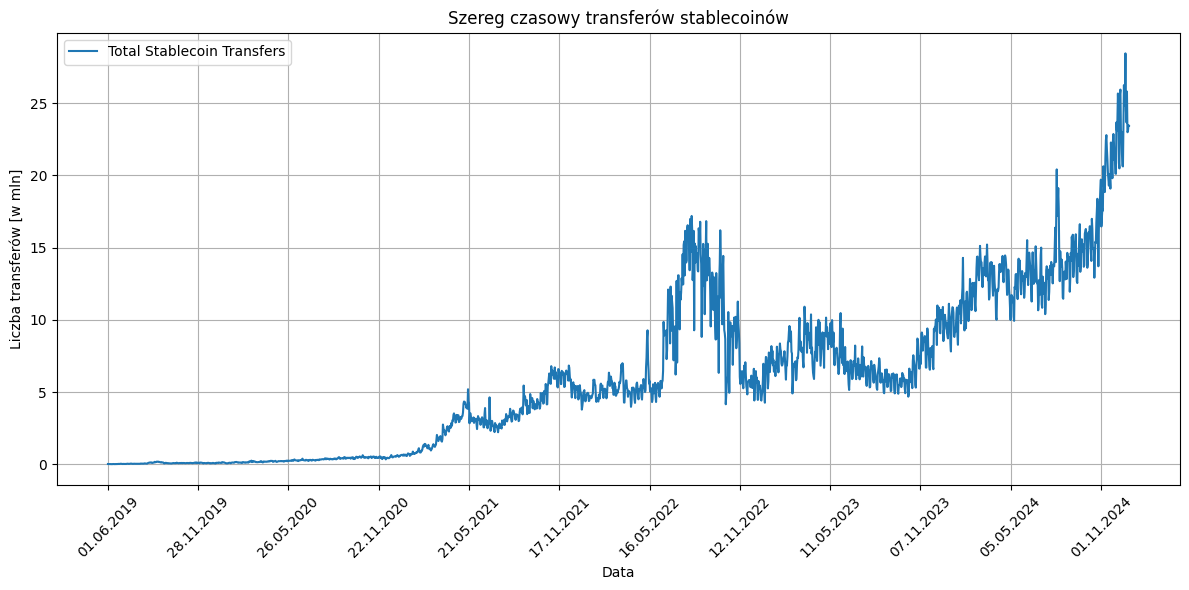

In [ ]:
# Rysowanie wykresu
# Funkcja formatowania osi Y na miliony
def millions_formatter(x, _):
    return f'{x / 1e6:.0f}'  # Dzielimy przez 1e6, zaokrąglamy do liczb całkowitych

# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_stables_transfers['Date'], final_data_stables_transfers['Total'], 
         label='Total Stablecoin Transfers', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.set_xticks(final_data_stables_transfers['Date'][::180])  # Wyświetlanie co 180 dni (co około 6 miesięcy)
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Formatowanie osi Y na miliony
ax.yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# Dodanie etykiet i tytułu
plt.xlabel('Data')  # Opis osi X
plt.ylabel('Liczba transferów [w mln]')  # Opis osi Y w milionach
plt.title('Szereg czasowy transferów stablecoinów')  # Tytuł wykresu 
plt.grid(True)  # Włączenie siatki
plt.legend()  # Dodanie legendy
plt.tight_layout()  # Dostosowanie layoutu

# Wyświetlenie wykresu
plt.show()

In [34]:
# Perform the ADF test on the 'Total' column of final_data_stables_transfers
result_transfers = adfuller(final_data_stables_transfers['Total'])

# Display the results of the ADF test for raw data
print('ADF Statistic (raw):', result_transfers[0])
print('p-value (raw):', result_transfers[1])
print('Critical Values (raw):')
for key, value in result_transfers[4].items():
    print(f'   {key}: {value}')

# Calculate the first difference of the transfers data
final_data_stables_transfers_diff = final_data_stables_transfers['Total'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_transfers = adfuller(final_data_stables_transfers_diff)

# Display the results of the ADF test for differenced data
print('ADF Statistic (diff):', result_diff_transfers[0])
print('p-value (diff):', result_diff_transfers[1])
print('Critical Values (diff):')
for key, value in result_diff_transfers[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): 1.4216748589364616
p-value (raw): 0.9972104168405682
Critical Values (raw):
   1%: -3.4336075477138945
   5%: -2.862979013123536
   10%: -2.567536068414148
ADF Statistic (diff): -12.396882675892739
p-value (diff): 4.653775301555832e-23
Critical Values (diff):
   1%: -3.4336091712699957
   5%: -2.862979729933645
   10%: -2.567536450078678


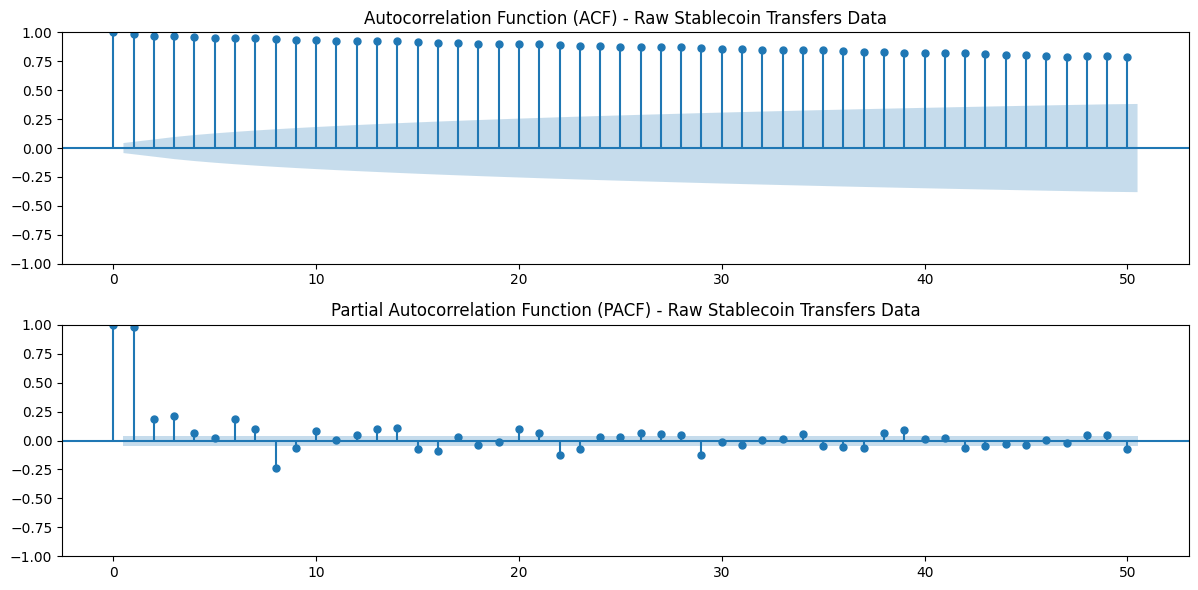

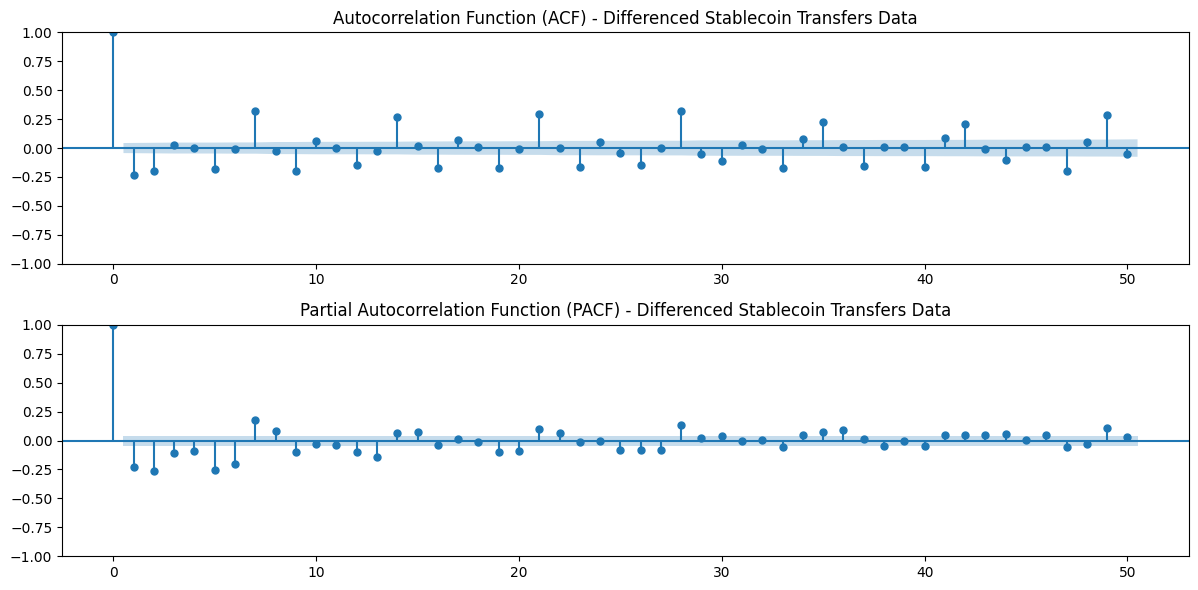

In [35]:
# Plotting ACF and PACF for raw stablecoin transfers data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_stables_transfers['Total'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw Stablecoin Transfers Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_stables_transfers['Total'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw Stablecoin Transfers Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced stablecoin transfers data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_stables_transfers_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Stablecoin Transfers Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_stables_transfers_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Stablecoin Transfers Data')

plt.tight_layout()
plt.show()

### Wolumen Transakcji Stablecoinów

source: https://app.artemis.xyz/stablecoins | *Transfer Volume* | Aggregate: 1d

In [26]:
print(data_stables_volume)

           Date           AUSD          BUSD           DAI          EURC  \
0     28-Nov-17            NaN           NaN           NaN           NaN   
1     29-Nov-17            NaN           NaN           NaN           NaN   
2     30-Nov-17            NaN           NaN           NaN           NaN   
3     01-Dec-17            NaN           NaN           NaN           NaN   
4     02-Dec-17            NaN           NaN           NaN           NaN   
...         ...            ...           ...           ...           ...   
2602  12-Jan-25    8504.552267  9.791402e+04  7.184971e+07  3.031670e+06   
2603  13-Jan-25   25595.876302  1.438715e+06  1.243327e+08  2.408762e+07   
2604  14-Jan-25  633176.958026  9.748743e+05  4.950743e+07  6.815534e+06   
2605  15-Jan-25  233664.985718  2.675525e+05  4.823140e+07  5.597954e+06   
2606  16-Jan-25      42.000000  7.523884e+05  5.604256e+07  1.090850e+07   

             FDUSD         PYUSD          USD0          USDC        USDGLO  \
0        

In [ ]:
# Konwersja kolumny "Date" na datetime
data_stables_volume['Date'] = pd.to_datetime(data_stables_volume['Date'], format='%d-%b-%y')

# Filtrowanie dat od 01.06.2019 do 27.12.2024
filtered_volume = data_stables_volume[
    (data_stables_volume['Date'] >= '2019-06-01') & 
    (data_stables_volume['Date'] <= '2024-12-27')
]

# Obliczenie kolumny 'Total' jako suma wolumenu wszystkich stablecoinów
filtered_volume['Total'] = filtered_volume.iloc[:, 1:].sum(axis=1)

# Zmiana formatu daty na DD.MM.YYYY
filtered_volume['Date'] = filtered_volume['Date'].dt.strftime('%d.%m.%Y')

# Zatrzymanie tylko kolumn "Date" i "Total"
final_data_stables_volume = filtered_volume[['Date', 'Total']]

# Wyświetlenie wyniku
print(final_data_stables_volume)

            Date         Total
550   01.06.2019  1.327025e+08
551   02.06.2019  7.323911e+07
552   03.06.2019  1.804161e+08
553   04.06.2019  2.687314e+08
554   05.06.2019  2.241583e+08
...          ...           ...
2582  23.12.2024  4.019582e+10
2583  24.12.2024  3.488069e+10
2584  25.12.2024  2.136835e+10
2585  26.12.2024  2.764748e+10
2586  27.12.2024  3.434262e+10

[2037 rows x 2 columns]


/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/2394388386.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_volume['Total'] = filtered_volume.iloc[:, 1:].sum(axis=1)
/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/2394388386.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_volume['Date'] = filtered_volume['Date'].dt.strftime('%d.%m.%Y')


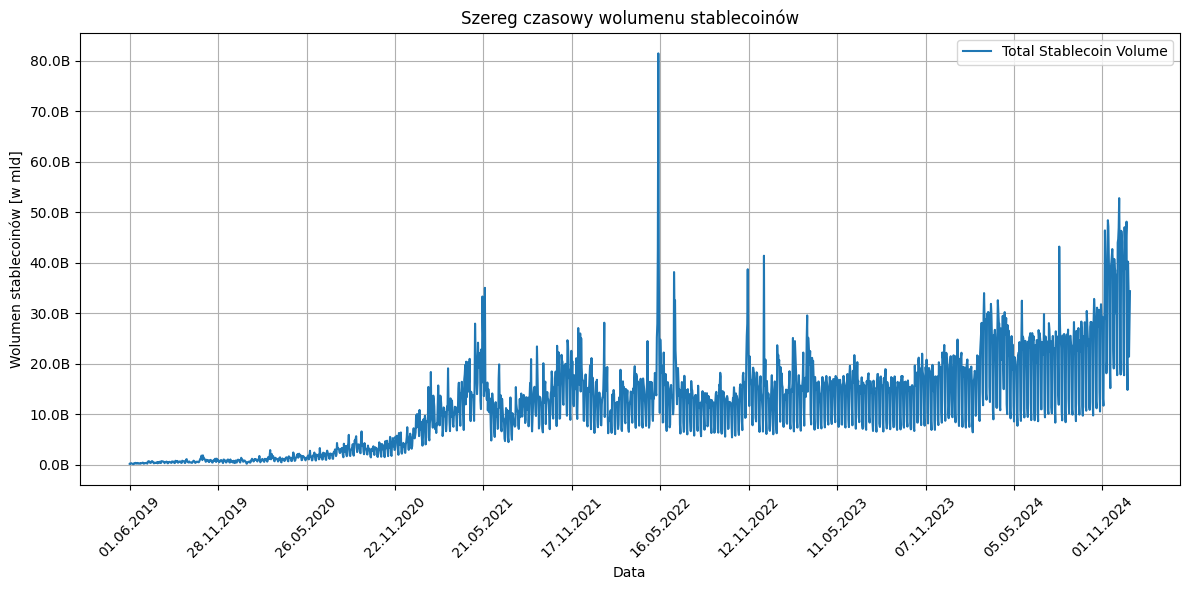

In [ ]:
# Funkcja formatowania osi Y na miliardy
def billions_formatter(x, _):
    return f'{x / 1e9:.1f}B'  # Dzielimy przez 1e9, aby wyświetlić w miliardach

# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.plot(final_data_stables_volume['Date'], final_data_stables_volume['Total'], 
         label='Total Stablecoin Volume', linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
ax.set_xticks(final_data_stables_volume['Date'][::180])  # Wyświetlanie dat co 180 dni (co około 6 miesięcy)
plt.xticks(rotation=45)  # Obrót etykiet na osi X

# Formatowanie osi Y na miliardy
ax.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))

# Dodanie etykiet i tytułu
plt.xlabel('Data')  # Opis osi X
plt.ylabel('Wolumen stablecoinów [w mld]')  # Opis osi Y w miliardach
plt.title('Szereg czasowy wolumenu stablecoinów')  # Tytuł wykresu Szereg czasowy wolumenu stablecoinów
plt.grid(True)  # Włączenie siatki
plt.legend()  # Dodanie legendy
plt.tight_layout()  # Dostosowanie layoutu

# Wyświetlenie wykresu
plt.show()

In [36]:
# Perform the ADF test on the 'Total' column of final_data_stables_volume
result_volume = adfuller(final_data_stables_volume['Total'])

# Display the results of the ADF test for raw data
print('ADF Statistic (raw):', result_volume[0])
print('p-value (raw):', result_volume[1])
print('Critical Values (raw):')
for key, value in result_volume[4].items():
    print(f'   {key}: {value}')

# Calculate the first difference of the volume data
final_data_stables_volume_diff = final_data_stables_volume['Total'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_volume = adfuller(final_data_stables_volume_diff)

# Display the results of the ADF test for differenced data
print('ADF Statistic (diff):', result_diff_volume[0])
print('p-value (diff):', result_diff_volume[1])
print('Critical Values (diff):')
for key, value in result_diff_volume[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): -0.9840149870740996
p-value (raw): 0.7590497289755209
Critical Values (raw):
   1%: -3.4336075477138945
   5%: -2.862979013123536
   10%: -2.567536068414148
ADF Statistic (diff): -14.826766913968584
p-value (diff): 1.9263379183250072e-27
Critical Values (diff):
   1%: -3.4336091712699957
   5%: -2.862979729933645
   10%: -2.567536450078678


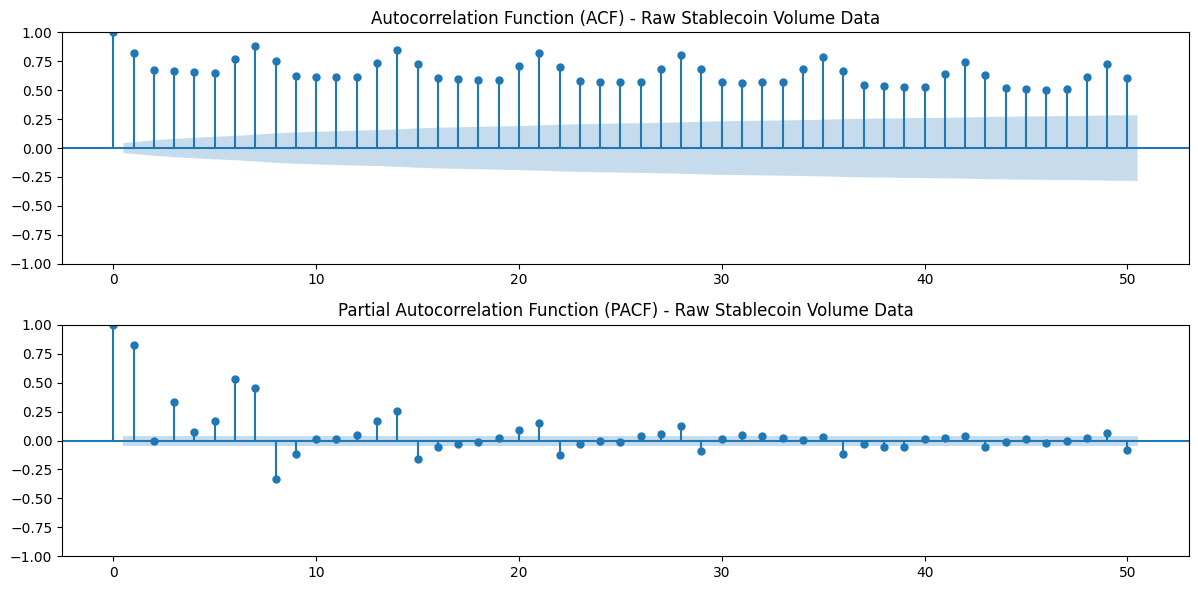

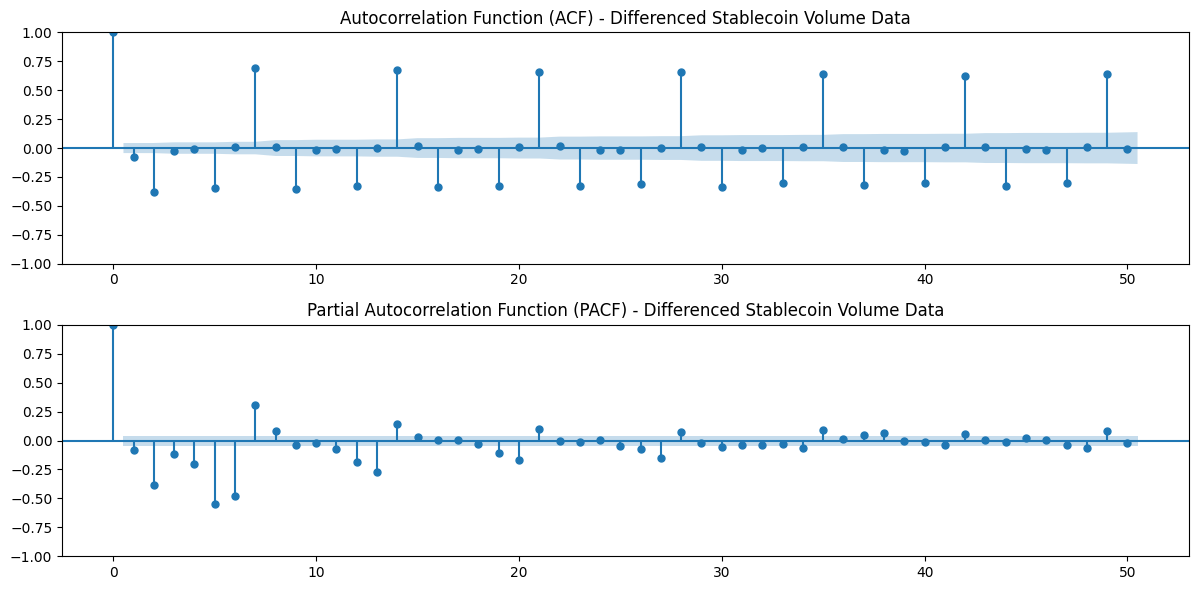

In [37]:
# Plotting ACF and PACF for raw stablecoin volume data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_stables_volume['Total'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw Stablecoin Volume Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_stables_volume['Total'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw Stablecoin Volume Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced stablecoin volume data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_stables_volume_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Stablecoin Volume Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_stables_volume_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Stablecoin Volume Data')

plt.tight_layout()
plt.show()

### Średnia Wartość Transeru Stablecoina w USD
source: https://app.artemis.xyz/stablecoins | *AVG Tx Size in USD* | Aggregate: 1d

In [29]:
print(data_avg_stables_tx_val_usd)

           Date           AUSD                BUSD          DAI  \
0     28-Nov-17            NaN                 NaN          NaN   
1     29-Nov-17            NaN                 NaN          NaN   
2     30-Nov-17            NaN                 NaN          NaN   
3     01-Dec-17            NaN                 NaN          NaN   
4     02-Dec-17            NaN                 NaN          NaN   
...         ...            ...                 ...          ...   
2602  12-Jan-25    2834.850756  19.760650763433325  9536.728118   
2603  13-Jan-25    4265.979384   269.9277638325758  7355.224764   
2604  14-Jan-25  105529.493004   191.7911343109471  4314.749041   
2605  15-Jan-25   58416.246430   58.12568656977416  3520.540225   
2606  16-Jan-25      42.000000  171.62144096474861  4211.509526   

                    EURC               FDUSD               PYUSD  \
0                    NaN                 NaN                 NaN   
1                    NaN                 NaN               

In [ ]:
# 1. Przetwarzanie danych
# Konwersja kolumny "Date" na datetime
data_avg_stables_tx_val_usd['Date'] = pd.to_datetime(data_avg_stables_tx_val_usd['Date'], format='mixed')

# Filtrowanie dat od 01.06.2019 do 27.12.2024
filtered_avg_value = data_avg_stables_tx_val_usd[
    (data_avg_stables_tx_val_usd['Date'] >= '2019-06-01') &
    (data_avg_stables_tx_val_usd['Date'] <= '2024-12-27')
]

# Wybierz tylko kolumny numeryczne (pomijając kolumnę Date)
numeric_cols = filtered_avg_value.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
filtered_avg_value['avg_value'] = filtered_avg_value[numeric_cols].mean(axis=1, skipna=True)

# Zmiana formatu daty na DD.MM.YYYY
filtered_avg_value['Date'] = filtered_avg_value['Date'].dt.strftime('%d.%m.%Y')

# Zatrzymanie tylko potrzebnych kolumn
final_data_avg_stables_tx_val_usd = filtered_avg_value[['Date', 'avg_value']]

/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/4059334912.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_avg_value['avg_value'] = filtered_avg_value[numeric_cols].mean(axis=1, skipna=True)
/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/4059334912.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_avg_value['Date'] = filtered_avg_value['Date'].dt.strftime('%d.%m.%Y')


/var/folders/h1/_tqx2vh95xxdkjs9vpksmflr0000gn/T/ipykernel_22527/3074836732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_avg_stables_tx_val_usd['Date'] = pd.to_datetime(final_data_avg_stables_tx_val_usd['Date'], format='%d.%m.%Y')


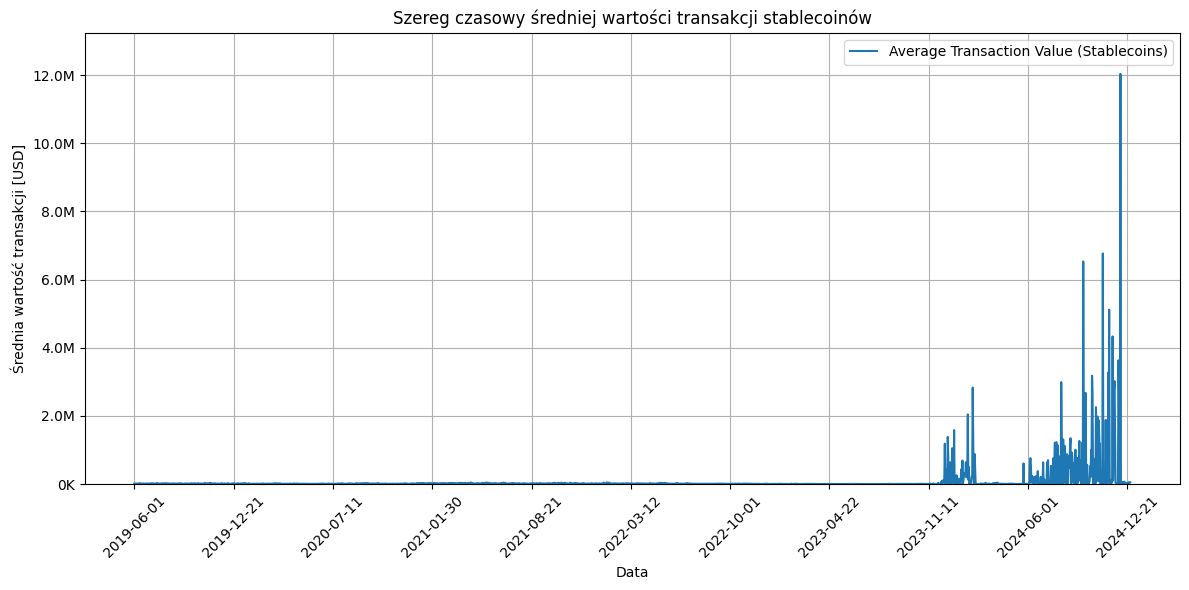

In [ ]:
# Rysowanie wykresu
plt.figure(figsize=(12, 6))

# Konwertujemy daty z powrotem na datetime dla lepszego wyświetlania
final_data_avg_stables_tx_val_usd['Date'] = pd.to_datetime(final_data_avg_stables_tx_val_usd['Date'], format='%d.%m.%Y')

plt.plot(final_data_avg_stables_tx_val_usd['Date'], 
         final_data_avg_stables_tx_val_usd['avg_value'],
         label='Average Transaction Value (Stablecoins)', 
         linewidth=1.5)

# Formatowanie osi X
ax = plt.gca()
n_ticks = 10
step = len(final_data_avg_stables_tx_val_usd) // n_ticks
ax.set_xticks(final_data_avg_stables_tx_val_usd['Date'][::step])

plt.xticks(rotation=45)

# Ustawienie zakresu osi Y od 0 do maksymalnej wartości z małym marginesem
y_max = final_data_avg_stables_tx_val_usd['avg_value'].max()
plt.ylim(0, y_max * 1.1)  # dodajemy 10% marginesu na górze

# Formatowanie osi Y na miliony
def millions_formatter(x, _):
    return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'

ax.yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# Dodanie etykiet i tytułu
plt.xlabel('Data')
plt.ylabel('Średnia wartość transakcji [USD]')
plt.title('Szereg czasowy średniej wartości transakcji stablecoinów') 
plt.grid(True)
plt.legend()
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()

*Note*: Nie jest to średnia wazona wolumenem lub kapitalizacją tylko średnia arytmetyczna wartosci transakcji w USD z wykrzystaniem jednego z 18 stablecoinów 

(*"AUSD","BUSD","DAI","EURC","FDUSD","PYUSD","USD0","USDC","USDGLO","USDP","USDS","USDT","USDY","USDe","cEUR","cKES","cREAL","cUSD"*)

In [38]:
# Perform the ADF test on the 'avg_value' column of final_data_avg_stables_tx_val_usd
result_avg_value = adfuller(final_data_avg_stables_tx_val_usd['avg_value'])

# Display the results of the ADF test for raw data
print('ADF Statistic (raw):', result_avg_value[0])
print('p-value (raw):', result_avg_value[1])
print('Critical Values (raw):')
for key, value in result_avg_value[4].items():
    print(f'   {key}: {value}')

# Calculate the first difference of the avg_value data
final_data_avg_stables_tx_val_usd_diff = final_data_avg_stables_tx_val_usd['avg_value'].diff().dropna()

# Perform the ADF test on the first difference
result_diff_avg_value = adfuller(final_data_avg_stables_tx_val_usd_diff)

# Display the results of the ADF test for differenced data
print('ADF Statistic (diff):', result_diff_avg_value[0])
print('p-value (diff):', result_diff_avg_value[1])
print('Critical Values (diff):')
for key, value in result_diff_avg_value[4].items():
    print(f'   {key}: {value}')

ADF Statistic (raw): -3.140780183110131
p-value (raw): 0.023678809133647605
Critical Values (raw):
   1%: -3.433605925774539
   5%: -2.862978297026843
   10%: -2.5675356871295394
ADF Statistic (diff): -12.131649772468897
p-value (diff): 1.7303947126380354e-22
Critical Values (diff):
   1%: -3.4336091712699957
   5%: -2.862979729933645
   10%: -2.567536450078678


In [39]:
# Perform the Ljung-Box test on the raw average transaction value data
ljung_box_result_avg_value = acorr_ljungbox(final_data_avg_stables_tx_val_usd['avg_value'], lags=[10], return_df=True)

# Display the results of the Ljung-Box test for raw data
print("Ljung-Box Test for Raw Average Transaction Value Data:")
print(ljung_box_result_avg_value)

# Perform the Ljung-Box test on the differenced average transaction value data
ljung_box_result_diff_avg_value = acorr_ljungbox(final_data_avg_stables_tx_val_usd_diff, lags=[10], return_df=True)

# Display the results of the Ljung-Box test for differenced data
print("\nLjung-Box Test for Differenced Average Transaction Value Data:")
print(ljung_box_result_diff_avg_value)

Ljung-Box Test for Raw Average Transaction Value Data:
      lb_stat      lb_pvalue
10  605.11625  1.410784e-123

Ljung-Box Test for Differenced Average Transaction Value Data:
       lb_stat     lb_pvalue
10  488.149524  1.502119e-98


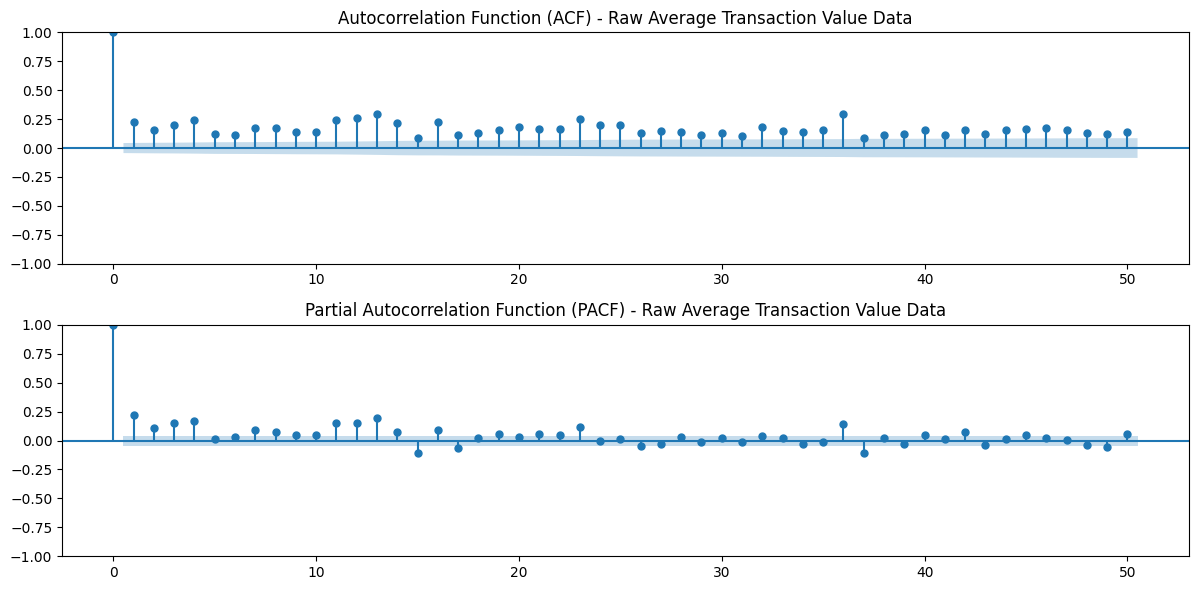

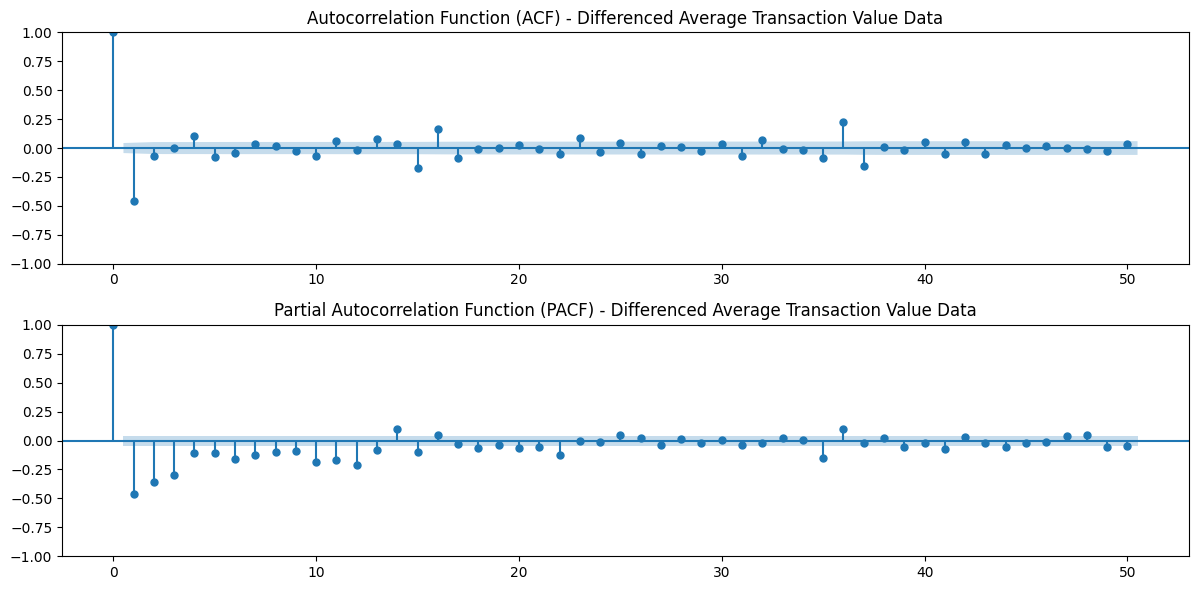

In [40]:
# Plotting ACF and PACF for raw average transaction value data
plt.figure(figsize=(12, 6))

# ACF plot for raw data
plt.subplot(2, 1, 1)
plot_acf(final_data_avg_stables_tx_val_usd['avg_value'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Raw Average Transaction Value Data')

# PACF plot for raw data
plt.subplot(2, 1, 2)
plot_pacf(final_data_avg_stables_tx_val_usd['avg_value'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Raw Average Transaction Value Data')

plt.tight_layout()
plt.show()

# Plotting ACF and PACF for differenced average transaction value data
plt.figure(figsize=(12, 6))

# ACF plot for differenced data
plt.subplot(2, 1, 1)
plot_acf(final_data_avg_stables_tx_val_usd_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Average Transaction Value Data')

# PACF plot for differenced data
plt.subplot(2, 1, 2)
plot_pacf(final_data_avg_stables_tx_val_usd_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Average Transaction Value Data')

plt.tight_layout()
plt.show()

# Model 

Y: final_data_Y_diff

X: 
- final_data_eth_diff
- final_data_spx_diff 
- final_data_usd_l_diff
- final_data_vix
- final_data_vix_diff
- final_data_tvl_diff
- final_data_stables_active_addresses_diff
- final_data_stables_transfers_diff
- final_data_stables_volume_diff
- final_data_avg_stables_tx_val_usd_diff

Zmienne opoźnione i dodać tu 